# <u><b>0) Préambule au code</b></u>
# 

## <b><u>0.1) Ensemble des variables à modifier en début d'exécution du Notebook :</u></b>
### !!! On attire l'attention du lecteur/utilisateur sur les variables ci dessous :
### <b>- Les chemins d'accès de données :</b> Ils sont définis localement, et depuis peu de façon relative au répertoire contenant ce notebook. Le lecteur/utilisateur est libre de les modifier par rapport à son propre environnement, mais il faudra alors veiller à rendre cette modification cohérence avec le bon accès aux fichiers présents ci-dessous dans les répertoires <b>../Cache_fichiers/</b>, <b>../Figures/</b>, etc.
### <b>- Les booléens d'activation/désactivation :</b> Attention, ces booléens (selon qu'ils prennent True ou False) activent (ou désactivent) des fonctions telles que la sauvegarde en local de fichiers créés à partir de données calculées dans ce notebook, la sauvegarde en local de figures, etc.
### <b>- !!! Le booléen <i>court_circuiter</i> !!! :</b> Attention, c'est le plus important de tous. Il permet d'activer/désactiver les étapes les plus longues en durée de calcul de ce notebook (entraînement des couches denses, optimisation d'hyper-paramètres, etc). SI L'UTILISATEUR TIENT A REFAIRE CES CALCULS, IL FAUT QU'IL SACHE QUE L'EXECUTION TOTALE DE CE NOTEBOOK PEUT PRENDRE PLUSIEURS HEURES DE CALCUL !!! La sauvegarde en local des données calculées dans le <b>/Cache_fichiers/</b> permet de sauter ces étapes longues tout en reprennant les bons résultats de calculs (le hasard est "bloqué" grâce à l'entier <i>rgn</i>=420 (voir plus bas) qui est systématiquement mis en entrée des variables <i>random_state</i> des fonctions qui le proposent). 
### - Par ailleurs, des booléens individuels de court-circuitage sont présents avant chaque section coûteuse en temps et en ressource de calcul. Ainsi, même si <i>court_circuiter</i> est = True, il est possible de laisser actif le calcul de chaque section au cas par cas (grâce à des opérateur de logique booléenne de type OU).

In [1]:
# Booléen d'activation (ou non) de l'installation des modules/librairies nécessaires au bon fonctionnement de ce Notebook (cf partie 1.1) du Notebook).
installation = False

### Tout ce qui concerne la base de donnée
path_b2d = "../B2D/"#"C:/Users/luked/Documents/Formation_Ingenieur_ML/Projets/P6/B2D/"

### Tout ce qui concerne les figures
# Sauvegarde des figures et chemin de données vers répertoire de stockage
sauvegarde_figure, path_fig = (
    True,
    "../Figures/1_"
)

### Tout ce qui concerne le cache des fichiers (pour ne pas avoir à refaire tous les calculs systématiquement)
# Sauvegarde des figures et chemin de données vers répertoire de stockage
sauvegarde_fichiers, path_cache_output = (
    True,
    "../Cache_fichiers/1_",#"C:/Users/luked/Documents/Formation_Ingenieur_ML/Projets/P5/Cache_fichiers/TestModeles/V04test_",
)

### Autres
# Booléens d'activation de la mise de côté des calculs longs, au profit du chargement des résultats de ces calculs, préalablement sauvegardés en local
court_circuiter = True

###### 
## <u><b>0.1) Installation - éventuelle - de librairies python :</b></u>
!!! Sautez cette étape si vous les avez déjà sur votre ordinateur, en mettant le booléen <i>installation</i> à <i>False</i>.

In [2]:
if installation :
    !pip install Pillow

###### 
## <u><b>0.2) Importations de librairies/modules/fonctions python :</b></u>

In [140]:
import os
import logging
from scipy.io import loadmat
### Quelques classiques des notebooks scientifiques
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
from seaborn import heatmap
### Traitement de texe
from re import split
from bs4 import BeautifulSoup
### Traitement d'image
from PIL import Image
### Mesure du temps
from tqdm import tqdm
from time import time
### Pickle
import pickle

In [4]:
### Sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [5]:
### Keras
from tensorflow.keras import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Resizing, Dense, Flatten, RandomFlip, RandomRotation, Conv2D, Dropout, MaxPooling2D
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import image_dataset_from_directory, set_random_seed

In [6]:
### Transfert Learning
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocin_vgg16
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as preprocin_mobnet2

###### 
## <u><b>0.3) Définition de constantes personnelles :</b></u>

In [7]:
### On détermine un entier qui servira à gêler le random state au sein des différentes fonctions
rgn = 420

In [8]:
### On bloque le hasrd de numpy et de tensorflow.keras
np.random.seed(rgn)
set_random_seed(rgn)

In [9]:
# Liste des répertoires nommés selon le schéma "identifiant_chien"
list_dir = np.asarray(os.listdir(path=path_b2d + 'Images'))
# Dictionnaire qui associe [identifiant, chien] à chaque indice de la liste des répertoire
n_idchiens = {n : split(string=list_dir[n], pattern='-') for n in range(len(list_dir))}

In [10]:
### Tableau des noms des couches 
noms_layers_vgg16 = np.array([layer.name for layer in VGG16(include_top=False).layers])

###### 
## <u><b>0.4) Définition de fonctions personnelles :</b></u>

Les 3 fonctions ci-dessous ne sont pas de moi, je ne me les approprie pas ! Elles viennent d'une discussion publique sur <i>Stackoverflow</i> (https://stackoverflow.com/questions/51125266/how-do-i-split-tensorflow-datasets), et servent lors de la re-spération du <i>data set</i> en jeux d'entraînement et de test, lors de la section consacrée à la construction de notre propre CNN.

In [11]:
def is_test(x, y):
    """Fonction qui renvoit un booléen True si son entrée x est un multiple de 4.
    Elle prend deux arguments car x,y = enumerate(dataset), par anticipation de la façon dont est écrit le code en section III.

    Arguments de cette fonction :
    x -- entier, issu de la fonction enumerate
    y -- objet python en train d'être enumérer"""
    return x % 4 == 0
###
def is_train(x, y):
    """Fonction qui renvoit un booléen True si son entrée x n'est pas un multiple de 4. 
    Elle prend deux arguments car x,y = enumerate(dataset), par anticipation de la façon dont est écrit le code en section III.

    Arguments de cette fonction :
    x -- entier, issu de la fonction enumerate
    y -- objet python en train d'être enumérer"""
    return not is_test(x, y)
### Fonction lambda adaptée à la restitution d'un dataset après affectation à l'un des deux jeux de test ou d'entraînement grâce aux fonctions ci-dessus
recover = lambda x,y: y

In [12]:
def model_fit(X_train, X_val, model_compile, nb_epochs, num_verbose, tab_callbacks):
    """Fonction qui réalise le fitting d'un objet de type Sequential ou Model du module keras de la librairie tensorflow, et mesure la durée de cet entraînement.

    Arguments de cette fonction :
    X_train -- dataset correspondant au jeu d'entraînement
    X_val -- dataset correspondant au jeu de validation
    model_compile -- objet de type Sequential ou Model, précédemment compilé
    nb_epochs -- entier, nombre d'itération -epoch- à faire lors de l'entraînement
    num_verbose -- entier, valeur de l'hyper-paramètre verbose de la fonction fit qui gère l'affichage de la progression de l'entraînement
    tab_callbacks -- liste d'objet de type Callback du module keras de la librairie tensorflow"""
    # Initialisatin de la mesure du temps
    t0 = time()
    # Entraînement/validation croisée
    modele_info = model_compile.fit(X_train, epochs=nb_epochs, validation_data=X_val, verbose=num_verbose, callbacks=tab_callbacks)
    # Mesure du temps d'entraînement
    delta_t = time()-t0
    print(f'Temps d`entraînement : {delta_t : >.1f} secondes')
    return model_compile, modele_info, delta_t

In [13]:
def plot_loss_score(model_info, model_eff, tab_X_test, tab_label, titre):
    """Fonction qui réalise l'affichage graphique de l'évolution temporelle de la fonction de perte, et du score de précision, lors de l'entraînement.

    Arguments de cette fonction :
    model_info -- objet de type Sequential ou Model, défini comme un modele précédemment compilé et entraîné (model_info = model_eff.fit()), permettant l'accès à un historique
    model_eff-- objet de type Sequential ou Model précédemment compilé et entraîné
    tab_X_test -- liste de datasets correspondant à des de jeux de test
    tab_label -- liste de labels correspondant à ces jeux de test
    titre -- chaîne de caractère, titre du graphe"""
    ### Varibales adaptées aux performances sur les différents jeux
    # une liste de tableaux de performances sur les jeux de test, et mesure du temps nécessaire
    t0 = time()
    perf_test = [model_eff.evaluate(X_test) for X_test in tab_X_test] #[model_eff.evaluate(X_test, y_test) for (X_test, y_test) in zip(tab_X_test, tab_y_test)] 
    delta_t = time()-t0
    print(f'Temps d`évaluation : {delta_t : >.1f} secondes')
    # un dictionnaire de l'historique sur validation, la liste des métriques, et la liste des itérations
    dico, metric, epoch = model_info.history, model_info.model.metrics_names, model_info.epoch
    ### Graphe
    plt.figure('Performances '+titre, figsize=(14,7)), plt.clf()
    axe1, axe2 = plt.subplot(1,2,1), plt.subplot(1,2,2)
    # Loss function = f(epochs)
    axe1.set_title(titre+'\nLoss function = f(Epochs)', fontsize=15, fontweight='bold'), axe1.set_ylabel('Loss function', fontsize=12), axe1.set_xlabel('Epochs', fontsize=12)
    axe1.plot(epoch, dico[metric[0]], label='train set'), axe1.plot(epoch, dico['val_'+metric[0]], label='val set')
    # Score = f(epochs)
    axe2.set_title(titre+'\nScore = f(Epochs)', fontsize=15, fontweight='bold'), axe2.set_ylabel('Accuracy', fontsize=12), axe2.set_xlabel('Epochs', fontsize=12), axe2.set_ylim([0,1])
    axe2.plot(epoch, dico[metric[1]], label='train set'), axe2.plot(epoch, dico['val_'+metric[1]], label='val set')
    # On complète les deux sous-figures avec les perf sur les jeux de test
    for perf, label in zip(perf_test, tab_label):
        axe1.plot([epoch[-1]+1], perf[0], marker='+', markersize=15, label=label+'test set')
        axe2.plot([epoch[-1]+1], perf[1], marker='+', markersize=15, label=label+'test set'), axe2.legend(loc='best')
    # Legendes
    axe1.legend(loc='best'), axe2.legend(loc='best')
    return perf_test[0], delta_t

In [14]:
def load_image_cc(fig_size, path_fig, titre_figure, format_image):
    """Fonction qui charge une image précédemment créée, utilisée en complément du court-circuitage.

    Arguments de cette fonction :
    fig_size -- tuple, taille de la fenêtre graphique
    path_fig -- chaîne de caractère, chemin relatif vers le répertoire de rangement de l'image précédemment créée
    titre_figure -- chaîne de caractère, titre du graphe
    format_image -- chaîne de caractère, format de sauvegarde de l'image précédente"""
    plt.figure(titre_figure, figsize=fig_size), plt.clf()
    axe = plt.subplot(1,1,1)
    with Image.open(path_fig + titre_figure + format_image) as image :
        axe.imshow(image), axe.axis('off')
    del axe, image

In [15]:
def pickle_save(object_to_save, suffix_title):
    """Fonction qui sauvegarde un objet en local grâce à des fonctions de la librairie pickle

    Arguments de cette fonction :
    object_to_save -- objet python à sauver
    suffix_title -- chaîne de caractère, titre de la sauvegarde en local, nécessite que la variable de chemin de données path_cache_output ait été définie avant"""
    # on ouvre le mode écriture de l'objet à sauvegarder dans le répertoire pointé par abs_path_cache_output
    file_pickel_ab = open(file=path_cache_output+suffix_title,mode='wb')
    # sauvegarde effective
    pickle.dump(object_to_save, file_pickel_ab)
    # fermeture du mode écriture
    file_pickel_ab.close()
    del file_pickel_ab

In [16]:
def pickle_load(suffix_title):
    """Fonction qui charge un objet sauvegardé localement, grâce à des fonctions de la librairie pickle

    Arguments de cette fonction :
    suffix_title -- chaîne de caractère, titre de la sauvegarde en local, nécessite que la variable de chemin de données path_cache_output ait été définie avant"""
    # on ouvre le mode lecture de l'objet rangé dans le répertoire pointé par abs_path_cache_output
    file_pickel_rb = open(file=path_cache_output+suffix_title,mode='rb')
    # chargement effectif
    objet = pickle.load(file_pickel_rb)
    # fermeture du mode lecture
    file_pickel_rb.close()
    del file_pickel_rb
    return objet

In [17]:
def dict_model(model_info, tps_info, model_eval, tps_eval, model_title):
    """Fonction qui crée un dictionnaire analogue à l'historique d'un Sequential/Model déjà entraîné

    Arguments de cette fonction :
    model_info -- objet de type Sequential ou Model, défini comme un modele précédemment compilé et entraîné, permettant l'accès à un historique
    tps_info -- durée de l'entraînement
    model_eval-- objet de type Sequential ou Model précédemment compilé et entraîné et après avoir subbit une évaluation
    tps_eval -- durée de l'évaluation
    tab_label -- liste de labels correspondant à ces jeux de test
    model_title -- chaîne de caractère, titre sous lequel on veut sauvegarder le modèle"""
    model_dict = {key : model_info.history[key] for key in model_info.history.keys()}
    model_dict['test_loss'], model_dict['test_sparse_categorical_accuracy'] = model_eval[0], model_eval[1]
    model_dict['train_time'], model_dict['test_time'] = tps_info, tps_eval
    if sauvegarde_fichiers :
        pickle_save(object_to_save=model_dict, suffix_title=model_title)

In [18]:
def init_conv_blocks_vgg16(noms_layers):
    """Fonction qui renvoie les 5 blocs de convolutions de base de notre propre CNN, de structure insipirée de celle de VGG16

    Arguments de cette fonction :
    noms_layers -- tableau de noms des différentes couches, de longeur 19"""
    myCNN = Sequential()
    ### 1er block
    myCNN.add(Conv2D(64, (3, 3), input_shape=(224, 224, 3), padding='same', activation='relu', name=noms_layers[1]))#
    #myCNN.add(Conv2D(64, (3, 3), padding='same', activation='relu', name=noms_layers[2]))
    myCNN.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), name=noms_layers[3]))
    ### 2nd block
    myCNN.add(Conv2D(128, (3, 3), padding='same', activation='relu', name=noms_layers[4]))
    #myCNN.add(Conv2D(128, (3, 3), padding='same', activation='relu', name=noms_layers[5]))
    myCNN.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), name=noms_layers[6]))
    ### 3eme block
    myCNN.add(Conv2D(256, (3, 3), padding='same', activation='relu', name=noms_layers[7]))
    myCNN.add(Conv2D(256, (3, 3), padding='same', activation='relu', name=noms_layers[8]))
    #myCNN.add(Conv2D(256, (3, 3), padding='same', activation='relu', name=noms_layers[9]))
    myCNN.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), name=noms_layers[10]))
    #### 4eme block
    myCNN.add(Conv2D(512, (3, 3), padding='same', activation='relu', name=noms_layers[11]))
    myCNN.add(Conv2D(512, (3, 3), padding='same', activation='relu', name=noms_layers[12]))
    #myCNN.add(Conv2D(512, (3, 3), padding='same', activation='relu', name=noms_layers[13]))
    myCNN.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), name=noms_layers[14]))
    #### 5eme block
    myCNN.add(Conv2D(512, (3, 3), padding='same', activation='relu', name=noms_layers[15]))
    myCNN.add(Conv2D(512, (3, 3), padding='same', activation='relu', name=noms_layers[16]))
    #myCNN.add(Conv2D(512, (3, 3), padding='same', activation='relu', name=noms_layers[17]))
    myCNN.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), name=noms_layers[18]))
    return myCNN

# 
# 
# <u><b>I) Données de travail</b></u>

###### 
## <u><b>I.1) Chargement de données</b></u>
###### 
On va charger les données grâce à la fonction <i>image_dataset_from_directory</i>, depuis le répertoire où est stockée la base de donnée [abrégée parfois B2D]. 

In [19]:
### Initilisation de la taille du batch, des dimension de l'image, et de la fraction du jeu de validation souhaitée lors de la séparation train test / valid test
batch_size, img_height, img_width, val_split = 32, 224, 224, 0.25

In [20]:
### Chargement des données sous la forme d'un tf.data.Dataset
# initilisation de mesure du temps
t0 = time()
# Chargement effectif
all_dataset = image_dataset_from_directory(
    directory=path_b2d+'Images/', 
    label_mode='int',
    batch_size=None,#
    image_size=(img_height, img_width), 
    shuffle=False,
    seed=rgn
)
# affichage du temps de cahrgrment
print(f'Dataset train chargé en {time()-t0 : .1f} secondes.')
del t0

Found 20580 files belonging to 120 classes.
Dataset train chargé en  1.1 secondes.


Regardons quelques unes des 1ères images ainsi chargée, dans l'ordre tel qu'elles ont été lues par la fonction <i>image_dataset_from_directory</i>

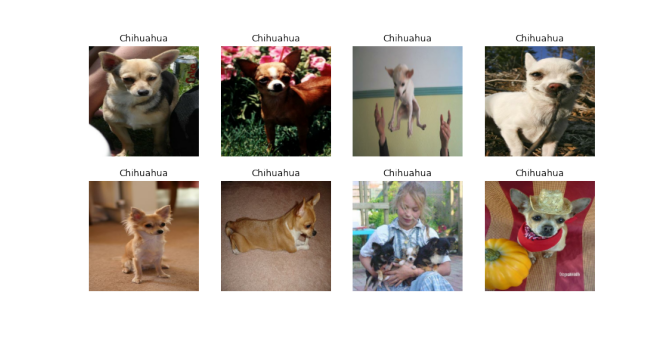

In [21]:
### Création du graphe hors court-circuitage des cellules
if court_circuiter==False:
    plt.figure('Contrôle chargement', figsize=(12,6)), plt.clf()
    for i, (images, labels) in enumerate(all_dataset.take(8)):
        axe = plt.subplot(2,4,i+1)
        axe.imshow(images.numpy().astype("int64")), axe.axis('off'), axe.set_title(n_idchiens[labels.numpy()][1])
    # Sauvegarde éventuelle
    if sauvegarde_figure :
        plt.savefig(path_fig+'01_controle_chargement.png')
    # On efface les variabled desormais inutiles
    del images, labels, i, axe
### En cas de court-circuitage
elif (court_circuiter)&(1==1):
    load_image_cc((12,6), path_fig, '01_controle_chargement', '.png')

On voit que la lecture et l'enregistrement des images se fait dossier par dossier, donc race après race. Il faudra donc veiller par la suite à mélanger (via une fonction <i>shuffle</i>) le jeu de données ainsi formé, de sorte à rompre ces séries d'image d'une même race. En effet, cela pourrait nuire à l'entraînement des nos modèles, surtout car ceux-ci fonctionnent par batchs.

###### 
## <u><b>I.2) Préparations des données</b></u>
###### 

### <u><b>I.2.a) Séparation en jeu d'entraînement et de test.</b></u>
On utilise pour cela les fonction définies plus haut en section <u><b>0.4</b></u>, qui retiennent une image sur 4 pour le jeu de test, le reste pour le jeu d'entraînement

In [22]:
test_dataset = all_dataset.enumerate().filter(is_test).map(recover)
train_dataset = all_dataset.enumerate().filter(is_train).map(recover)

Affichons désormais quelques image selon qu'elles ont été classées <i>train set</i> (ligne du bas) ou <i>test set</i> (ligne du bas).

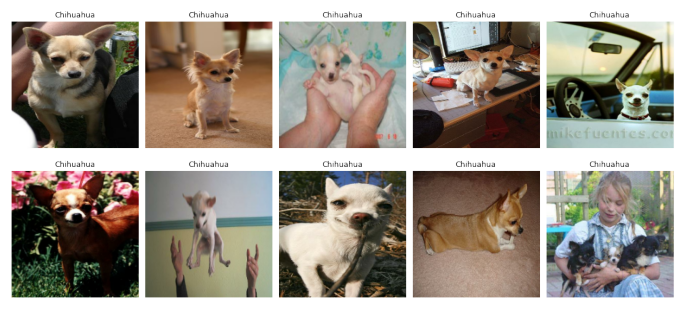

In [23]:
### Création du graphe hors court-circuitage des cellules
if court_circuiter==False:
    plt.figure('Contrôlel de la séparation train-test', figsize=(15,7)), plt.clf()
    # Ligne du haut : jeu de test
    for i, (images, labels) in enumerate(test_dataset.take(5)):
        axe = plt.subplot(2,5,i+1)
        axe.imshow(images.numpy().astype("int64")), axe.axis('off'), axe.set_title(n_idchiens[labels.numpy()][1])
    # Ligne du bas : jeu de train
    for i, (images, labels) in enumerate(train_dataset.take(5)):
        axe = plt.subplot(2,5,i+6)
        axe.imshow(images.numpy().astype("int64")), axe.axis('off'), axe.set_title(n_idchiens[labels.numpy()][1])
    plt.tight_layout(h_pad=1)
    if sauvegarde_figure :
        plt.savefig(path_fig+'02_controle_separation_train_test.png')
    del images, labels, i, axe
### En cas de court-circuitage
elif (court_circuiter)&(1==1):
    load_image_cc((12,6), path_fig, '02_controle_separation_train_test', '.png')

Grâce à l'image précédente, on peut vérifier que le décompte un sur quatre est bien fait.

Calculons désormais la taille de chacun de ces jeux, ainsi que le nombre de races différentes en leurs sein (afin de vérifier qu'elles sont bien toutes réparties entre les deux jeux).

In [24]:
nb_races_train, train_size = len(np.unique([elem[1] for elem in train_dataset.as_numpy_iterator()])), len([elem[1] for elem in train_dataset.as_numpy_iterator()])
print(f'Le jeu d`entraînement est composé de {train_size : >6.0f} images issues de {nb_races_train : >3.0f} races différentes.')
nb_races_test, test_size = len(np.unique([elem[1] for elem in test_dataset.as_numpy_iterator()])), len([elem[1] for elem in test_dataset.as_numpy_iterator()])
print(f'Le jeu de test est composé de {test_size : >6.0f} images issues de {nb_races_test : >3.0f} races différentes.')

Le jeu d`entraînement est composé de  15435 images issues de 120 races différentes.
Le jeu de test est composé de   5145 images issues de 120 races différentes.


C'est bien le cas, nous voici rassurés, nous pouvons passer à la suite.

In [25]:
# on effacce les varibales devenues inutiles
del all_dataset

### <u><b>I.2.b) Shuffle des deux jeux.</b></u>
Mélangeons les jeux dans leur intégralité (grâce à la taille de chacun des deux jeux précédents passée en argument <i>buffer_size</i> de la fonction <i>shuffle</i>) afin que jamais les algorithmes ne voient de longues chaînes d'image de la même race se présenter à leur entrée.

In [26]:
train_dataset = train_dataset.shuffle(buffer_size=train_size, reshuffle_each_iteration=False, seed=rgn)
test_dataset = test_dataset.shuffle(buffer_size=test_size, reshuffle_each_iteration=False, seed=rgn)

Assurons nous de la bonne perfomramnce du mélange par un affichage graphique similaire au précédent (jeu de test en haut, jeu d'entraînement sur la ligne du bas).

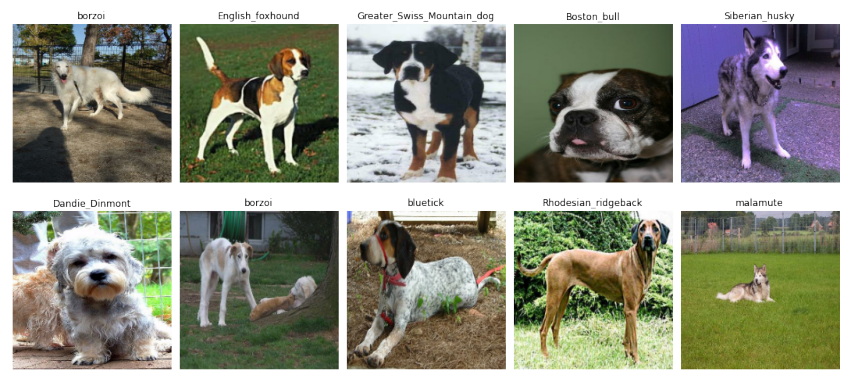

In [27]:
### Création du graphe hors court-circuitage des cellules
if court_circuiter==False:
    plt.figure('Contrôlel du shuffle sur train-test', figsize=(15,7)), plt.clf()
    for i, (images, labels) in enumerate(test_dataset.take(5)):
        axe = plt.subplot(2,5,i+1)
        axe.imshow(images.numpy().astype("int64")), axe.axis('off'), axe.set_title(n_idchiens[labels.numpy()][1])
    for i, (images, labels) in enumerate(train_dataset.take(5)):
        axe = plt.subplot(2,5,i+6)
        axe.imshow(images.numpy().astype("int64")), axe.axis('off'), axe.set_title(n_idchiens[labels.numpy()][1])
    plt.tight_layout(h_pad=1)
    if sauvegarde_figure :
        plt.savefig(path_fig+'03_controle_shuffle_train_test.png')
    del images, labels, i, axe
### En cas de court-circuitage
elif (court_circuiter)&(1==1):
    load_image_cc((15,7), path_fig, '03_controle_shuffle_train_test', '.png')

### <u><b>I.2.c) Jeu de validation.</b></u>
Nous aurons également besoin d'un jeu de validation. Nous le créons à partir du <i>train set</i> de nouveau grâce aux fonctions <i>is_test</i>/<i>is_train</i> et <i>recover</i> déjà utilisée au début de la <b>section I.1</b>, afin de respecter de nouveau un rapport 25% validation - 75% entraînement.

In [28]:
valid_dataset = train_dataset.enumerate().filter(is_test).map(recover)
train_dataset = train_dataset.enumerate().filter(is_train).map(recover)

De nouveau, on vérifie que la sélection a bien laissé des éléments de 120 races différentes au sein de ces deux jeux. 

In [29]:
nb_races_train, train_size = len(np.unique([elem[1] for elem in train_dataset.as_numpy_iterator()])), len([elem[1] for elem in train_dataset.as_numpy_iterator()])
print(f'Le nouveu jeu d`entraînement est composé de {train_size : >6.0f} images issues de {nb_races_train : >3.0f} races différentes.')
nb_races_valid, valid_size = len(np.unique([elem[1] for elem in valid_dataset.as_numpy_iterator()])), len([elem[1] for elem in valid_dataset.as_numpy_iterator()])
print(f'Le jeu de validation est composé de {test_size : >6.0f} images issues de {nb_races_test : >3.0f} races différentes.')

Le nouveu jeu d`entraînement est composé de  11576 images issues de 120 races différentes.
Le jeu de validation est composé de   5145 images issues de 120 races différentes.


C'est bien le cas. 

Vérifions graphiquement que la sélection d'une image sur quatre c'est bien faite. De nouveau, le jeux d'entraînement sera dans la ligne du bas de la figure suivante.

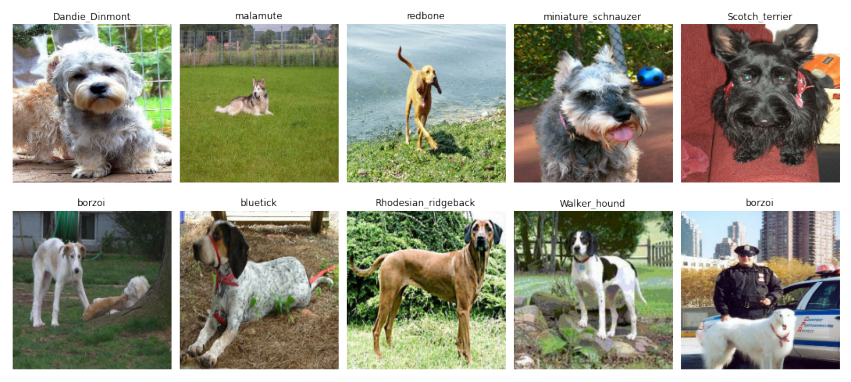

In [30]:
### Création du graphe hors court-circuitage des cellules
if court_circuiter==False:
    plt.figure('Contrôle séparation train-valid', figsize=(15,7)), plt.clf()
    for i, (images, labels) in enumerate(valid_dataset.take(5)):
        axe = plt.subplot(2,5,i+1)
        axe.imshow(images.numpy().astype("int64")), axe.axis('off'), axe.set_title(n_idchiens[labels.numpy()][1])
    for i, (images, labels) in enumerate(train_dataset.take(5)):
        axe = plt.subplot(2,5,i+6)
        axe.imshow(images.numpy().astype("int64")), axe.axis('off'), axe.set_title(n_idchiens[labels.numpy()][1])
    plt.tight_layout(h_pad=1)
    if sauvegarde_figure :
        plt.savefig(path_fig+'04_controle_separation_train_valid.png')
    del images, labels, i, axe
### En cas de court-circuitage
elif (court_circuiter)&(1==1):
    load_image_cc((15,7), path_fig, '04_controle_separation_train_valid', '.png')

Comme précédemment, on peut utiliser la ligne du bas de la figure précédente pour constater la bonne sélection "1 image pour le jeu de validation, les 3 suivantes restent dans le jeu d'entraînement".

###### 
### <u><b>I.1.d) Batch :</b></u>
Enfin, on divise les trois jeux en <i>batch</i> de même taille.

In [31]:
train_dataset = train_dataset.batch(batch_size=batch_size)
valid_dataset = valid_dataset.batch(batch_size=batch_size)
test_dataset = test_dataset.batch(batch_size=batch_size)

Nous pouvons désormais passer au <i>transfert learning</i>.

# 
# 
# <u><b>II) <i>Transfert Learning</i>.</b></u>
Nous allons tester deux modèles de réseaux pré-entraînés :
- VGG16, qui est utilisé comme exemple aplicatif dans l'un des cours associés à ce projet, et dont l'architecture est relativement simple à aborder et comprendre pour un étudiant novice comme moi.
- MobileNetV2, d'architecture plus complexe, reposant notamment sur des couches de convolution <i>depthwise</i>, ce qui augure peut être une meilleure détection de <i>features</i> caractéristiques au sein des images.

Pour chacun de ces types de réseaux pré-entraînés, nous allons faire subbir deux types actions, conformément à ce qui nous est imposé dans le cahier des charges du projet :
- dans un premier temps, on conservera toutes les couches, en ne ré-entraînant que les/la dernière(s) couche(s) dense(s) (abrégée par la suite <i>CCC</i> pour Couche Complètement Connectée) ;
- dans un second temps, on supprimera les/la CCC finale(s) et on ne ré-entraînera pas les autres couches.

Notons qu'à chaque fois, une CCC supplémentaire à 120 neurones sera rajoutée à la fin de chaque architecture. Ce sera elle qui fera la classification finale, par calcul d'une probabilité d'apparetance à chacune des 120 races. Les poids de ses connexions avec les couches précédentes seront quant à eux systématiquement entraînés.

###### 
## <u><b>II.1) VGG16</b></u>
###### 

### <u><b>II.1.a) Pre-processing adapté.</b></u> 
Commençons par appliquer un pré-traitement conforme aux exigences de VGG16 aux batchs de nos 3 jeux (via la fonction prévue à cet effet dans le module <b>tf.keras.applications.vgg16</b>).

In [32]:
train_ds_vgg16 = train_dataset.map(lambda x,y : (preprocin_vgg16(x),y))
valid_ds_vgg16 = valid_dataset.map(lambda x,y : (preprocin_vgg16(x),y))
test_ds_vgg16 = test_dataset.map(lambda x,y : (preprocin_vgg16(x),y))

Un point à propos des notations : le modèle dont l'architecture conserve les CCC originales et les ré-entraîne sera noté par le suffixe <i>_vgg16_a</i>, quand celui sans CCC originales sera noté par le suffixe <i>_vgg16_b</i>

### <u><b>II.1.b) En ré-entraînant les CCC finales.</b></u> 
!!! IMPORTANT !!! Notons ci-dessous le booléen <i>court_circuiter_vgg16_a</i>. Si il est False, il permet de quand même maintenir les étapes de calculs malgré l'activaltion du booléen <i>court_circuiter</i>. En effet, chaque cellule sera précédée par la condition <i>if (court_circuiter==False)|(court_circuiter_vgg16_a==False):</i>. Donc il faut que les deux booléens soient True pour désacriver les calculs suivants. 

Notons que ce genre de booléens sera systématiuement mis en entrée de chaque cellule de calculs "lourds".

In [33]:
court_circuiter_vgg16_a = True

Créeons l'architecture attendue, et compilons ce modèle.

In [34]:
if (court_circuiter==False)|(court_circuiter_vgg16_a==False):
    ### Création du modèle VGG-16 implementé par Keras
    # Charger VGG-16 pré-entraîné sur ImageNet et sans les couches fully-connected
    vgg16_a = VGG16(weights="imagenet", include_top=True, input_shape=(224, 224, 3))
    # Désactivation de l'apprentissage des couches de VGG16 qu'on a conservées
    for layer in vgg16_a.layers[:-2]:
        layer.trainable = False
    # Ajout d'une CCC finale à 120 sorties
    vgg16_a = Model(inputs=vgg16_a.input, outputs=Dense(120, activation='softmax')(vgg16_a.output))
    # Compiler le modèle (en laissant par défaut optimizer sur une méthode de descente de gradient nommée 'rmsprop')
    vgg16_a.compile(loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])
    print('Les dimensions de la sortie du VGG16 (rendu ainsi effectif) sont :', vgg16_a.output_shape)

On crée deux objet de type <i>callback</i> afin de nous aider à gérer l'entraînement du modèle :
- un EarlyStopping, qui devra veiller à interrompre l'entraînement si jamais la précision sur le jeu de validation ne progresse plus pendant plusieurs itérations d'affilée (afin d'éviter de maintenir un apprentissage pour rien pendant de longues itérations restantes.
- un ModelCheckpoint, qui mettra à jour une sauvegarde locale du meilleur jeu de poids (en terme de perfomances en précision sur le jeu de validation) jusqu'à présent.

In [35]:
if (court_circuiter==False)|(court_circuiter_vgg16_a==False):
    ### Initialisation d'un encoder d'étiquette et de Callbacks
    estop_vgg16_a = EarlyStopping(verbose=1, monitor='val_sparse_categorical_accuracy', min_delta=0.025, patience=7)
    mchkp_vgg16_a = ModelCheckpoint(verbose=1, filepath=path_cache_output+'vgg16_a_best.h5', monitor='val_sparse_categorical_accuracy', save_best_only=True)

On peut entraîner le modèle :

In [36]:
if (court_circuiter==False)|(court_circuiter_vgg16_a==False):
    vgg16_a, vgg16_a_info, tps_train_vgg16_a = model_fit(
        train_ds_vgg16, X_val=valid_ds_vgg16, model_compile=vgg16_a, nb_epochs=15, num_verbose=0, tab_callbacks=[estop_vgg16_a, mchkp_vgg16_a]
    )

Affichons l'évolution de la fonction perte et de la précision en fonction du temps, et sur chacun de ces deux jeux (traits bleus/jaune pour les jeux de train/validation), ainsi qu'un calul de ces deux métriques sur le jeu de test (croix verte) grâce au meilleur modèle suavegardé par le ModelCheckPoint.

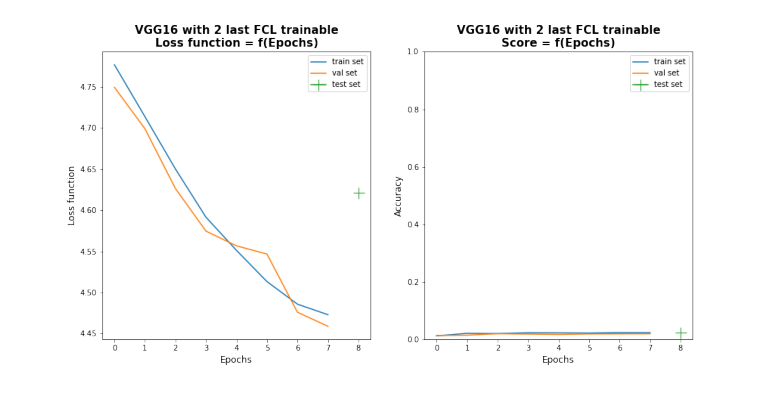

In [37]:
if (court_circuiter==False)|(court_circuiter_vgg16_a==False):
    vgg16_a_eval, tps_test_vgg16_a = plot_loss_score(
        vgg16_a_info, load_model(path_cache_output+'vgg16_a_best.h5'), [test_ds_vgg16], [''], 'VGG16 with 2 last FCL trainable'
    )
    if sauvegarde_figure :
        plt.savefig(path_fig+'05_vgg166_a_plot_scores.png')
else:
    load_image_cc((14,7), path_fig, '05_vgg166_a_plot_scores', '.png')

C'est très mauvais :
- Il y a très peu de variation de la fonction de perte
- DOnc les scores de précisions restent proches de leur valeur initiales, qui est quasimment nulle.
- L'évolution est tellement lente que le EarlyStoping a intérompu prématurément l'entraînement.

On prend le temps de sauvegarder en local toutes ces valeurs dans un dictionnaire :

In [38]:
if (court_circuiter==False)|(court_circuiter_vgg16_a==False):
    if 1==1:
        dict_model(vgg16_a_info, tps_train_vgg16_a, vgg16_a_eval, tps_test_vgg16_a, 'vgg16_a_dict')
    else :
        vgg16_a_dict = {key : vgg16_a_info.history[key] for key in vgg16_a_info.history.keys()}
        vgg16_a_dict['test_loss'], vgg16_a_dict['test_sparse_categorical_accuracy'] = vgg16_a_eval[0], vgg16_a_eval[1]
        vgg16_a_dict['train_time'], vgg16_a_dict['test_time'] = tps_train_vgg16_a, tps_test_vgg16_a
        pickle_save(object_to_save=vgg16_a_dict, suffix_title='vgg16_a_dict')

On peut donc passer à la suppression des CCC finales, et effacer les varibales désormais inutiles.

In [39]:
if (court_circuiter==False)|(court_circuiter_vgg16_a==False):
    del vgg16_a, vgg16_a_info, tps_train_vgg16_a, vgg16_a_eval, tps_test_vgg16_a, layer, estop_vgg16_a, mchkp_vgg16_a

### <u><b>II.1.c) Suppression des CCC.</b></u> 
Espérons avoir de meilleurs résultats en supprimant les CCC finales de VGG16. 

Notons le nouveau booléen de court-circuitage local <i>court_circuiter_vgg16_b</i>.

Les étapes suivantes étant très similaires à celles écrites dans la section <b>II.1.b</b> (si ce n'est pour l'initialisation de l'architecture différente), on se passera de rédiger des commentaire d'ici à la production de la figure de perfomances (fonction de perte, précision) sur les différents jeux.

In [40]:
court_circuiter_vgg16_b = True

In [41]:
if (court_circuiter==False)|(court_circuiter_vgg16_b==False):
    ### Création du modèle VGG-16 implementé par Keras
    # Charger VGG-16 pré-entraîné sur ImageNet et sans les couches fully-connected
    vgg16_b = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
    # Désactivation de l'apprentissage des couches de VGG16 qu'on a conservées
    for layer in vgg16_b.layers:
        layer.trainable = False
    # Ajout d'une CCC finale à 120 sorties
    vgg16_b = Model(inputs=vgg16_b.input, outputs=Dense(120, activation='softmax')(Flatten()(vgg16_b.output)))
    # Compiler le modèle (en laissant par défaut optimizer sur une méthode de descente de gradient nommée 'rmsprop')
    vgg16_b.compile(loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])
    print('Les dimensions de la sortie du VGG16 (rendu ainsi effectif) sont :', vgg16_b.output_shape)

In [42]:
if (court_circuiter==False)|(court_circuiter_vgg16_b==False):
    ### Initialisation d'un encoder d'étiquette et de Callbacks
    estop_vgg16_b = EarlyStopping(verbose=1, monitor='val_sparse_categorical_accuracy', min_delta=0.025, patience=7)
    mchkp_vgg16_b = ModelCheckpoint(verbose=1, filepath=path_cache_output+'vgg16_b_best.h5', monitor='val_sparse_categorical_accuracy', save_best_only=True)

In [43]:
if (court_circuiter==False)|(court_circuiter_vgg16_b==False):
    vgg16_b, vgg16_b_info, tps_train_vgg16_b = model_fit(
        train_ds_vgg16, X_val=valid_ds_vgg16, model_compile=vgg16_b, nb_epochs=15, num_verbose=0, tab_callbacks=[estop_vgg16_b, mchkp_vgg16_b]
    )

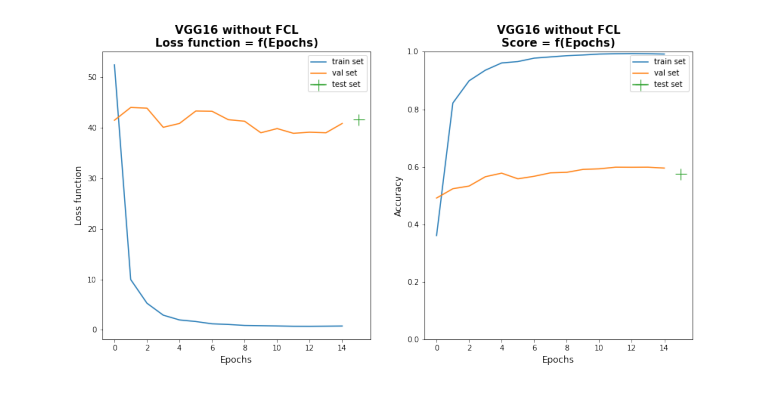

In [44]:
if (court_circuiter==False)|(court_circuiter_vgg16_b==False):
    vgg16_b_eval, tps_test_vgg16_b = plot_loss_score(
        vgg16_b_info, load_model(path_cache_output+'vgg16_b_best.h5'), [test_ds_vgg16], [''], 'VGG16 without FCL'
    )
    if sauvegarde_figure :
        plt.savefig(path_fig+'06_vgg166_b_plot_scores.png')
else:
    load_image_cc((14,7), path_fig, '06_vgg166_b_plot_scores', '.png')    
#plot_loss_score(model_info=vgg16_b_info, model_eff=load_model(path_cache_output+'vgg16_b_best.h5'), tab_X_test=[test_ds_vgg16], tab_label=[''], titre='VGG16 without FCL')

C'est bien mieux ! Néanmoins, on constate un sur-apprentissage assez fort.

In [45]:
if (court_circuiter==False)|(court_circuiter_vgg16_b==False):
    dict_model(vgg16_b_info, tps_train_vgg16_b, vgg16_b_eval, tps_test_vgg16_b, 'vgg16_b_dict')

In [46]:
if (court_circuiter==False)|(court_circuiter_vgg16_b==False):
    del vgg16_b, vgg16_b_info, tps_train_vgg16_b, vgg16_b_eval, tps_test_vgg16_b, layer, estop_vgg16_b, mchkp_vgg16_b

Maintenant, passons aux mêmes types de modifications d'architecture, mais pour les modèles issus de MobileNetV2 (on efface donc les jeux de données pré-traités spécialement pour l'entraînement de VGG16)

In [47]:
del train_ds_vgg16, test_ds_vgg16, valid_ds_vgg16

###### 
## <u><b>II.2) MobileNetV2</b></u>
###### 

### <u><b>II.2.a) Pre-processing adapté.</b></u> 
De nouveau, il nous faut appliquer un pré-traitement conforme aux exigences de MobileNEtV2 aux batchs de nos 3 jeux (via la fonction prévue à cet effet dans le module <b>tf.keras.applications.mobilenet_v2</b>).

In [48]:
train_ds_mobnet2 = train_dataset.map(lambda x,y : (preprocin_mobnet2(x),y))
valid_ds_mobnet2 = valid_dataset.map(lambda x,y : (preprocin_mobnet2(x),y))
test_ds_mobnet2 = test_dataset.map(lambda x,y : (preprocin_mobnet2(x),y))

Un point à propos des notations : le modèle dont l'architecture conserve la CCC originale finale de MobileNetV2 et les ré-entraîne sera noté par le suffixe <i>_mobnet2_a</i>, quand celui sans CCC originale sera noté par le suffixe <i>_mobnet2_b</i>

Reprenons le 1er type de modification d'architecture : conservation de la CCC finale de MobileNetV2 et ré-entraînement des dernièrezs couches.
### <u><b>II.2.b) En re-entraînant 2 CCC.</b></u> 
Notons la présence du booléen de court-circuitage local <i>court_circuiter_mobnet2_a</i>. De nouveau, les étapes sont assez similaires à ce qu'on a fait avec VGG16, donc on réservera l'essentiel de nos commentaires pour l'affichage des performances de cette architecture.

In [49]:
court_circuiter_mobnet2_a = True

In [50]:
if (court_circuiter==False)|(court_circuiter_mobnet2_a==False):
    ### Création du modèle MobileNetV2 implementé par Keras
    # Charger MobileNetV2 pré-entraîné sur ImageNet et avec les couches fully-connected
    mobnet2_a = MobileNetV2(weights="imagenet", include_top=True, input_shape=(224, 224, 3))
    # Désactivation de l'apprentissage des couches de MobileNetV2 qu'on a conservées
    for layer in mobnet2_a.layers[:-2]:
        layer.trainable = False
    # Baseline effective
    mobnet2_a = Model(inputs=mobnet2_a.input, outputs=Dense(120, activation='softmax')(mobnet2_a.output))
    # Compiler le modèle (en laissant par défaut optimizer sur une méthode de descente de gradient nommée 'rmsprop')
    mobnet2_a.compile(loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])
    print('Les dimensions de la sortie du MobileNetV2 (rendu ainsi effectif) sont :', mobnet2_a.output_shape)

On ré-introduit un EarlyStopping et un ModelCheckpoint pour les mêms raisons que précédemment.

In [51]:
if (court_circuiter==False)|(court_circuiter_mobnet2_a==False):
    ### Initialisation d'un encoder d'étiquette et de Callbacks
    estop_mobnet2_a = EarlyStopping(verbose=1, monitor='val_sparse_categorical_accuracy', min_delta=0.025, patience=7)
    mchkp_mobnet2_a = ModelCheckpoint(verbose=1, filepath=path_cache_output+'mobnet2_a_best.h5', monitor='val_sparse_categorical_accuracy', save_best_only=True)

In [52]:
if (court_circuiter==False)|(court_circuiter_mobnet2_a==False):
    mobnet2_a, mobnet2_a_info, tps_train_mobnet2_a = model_fit(
        train_ds_mobnet2, X_val=valid_ds_mobnet2, model_compile=mobnet2_a, nb_epochs=15, num_verbose=0, 
        tab_callbacks=[estop_mobnet2_a, mchkp_mobnet2_a]
    )

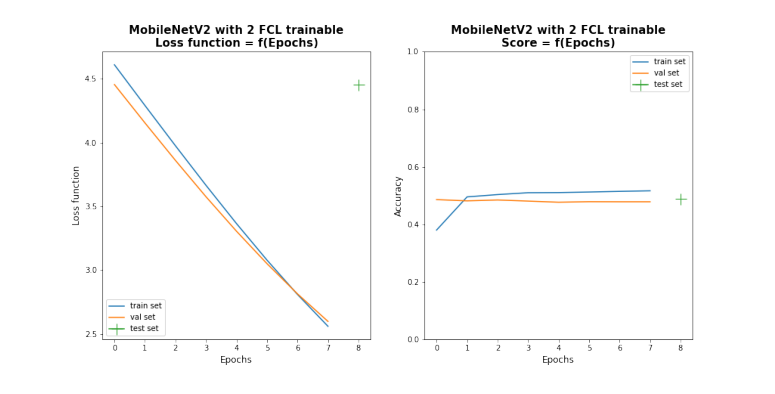

In [53]:
if (court_circuiter==False)|(court_circuiter_mobnet2_a==False):
    mobnet2_a_eval, tps_test_mobnet2_a = plot_loss_score(
        mobnet2_a_info, load_model(path_cache_output+'mobnet2_a_best.h5'), [test_ds_mobnet2], [''], 'MobileNetV2 with 2 FCL trainable'
    )
    if sauvegarde_figure :
        plt.savefig(path_fig+'07_mobnet2_a_plot_scores.png')
else:
    load_image_cc((14,7), path_fig, '07_mobnet2_a_plot_scores', '.png')    

On retrouve un PB similaire à ce qu'on avait avec VGG16 : très peu d'évolution de la fonction de perte, donc peu de progression de l'entraînement (interrompu d'ailleurs par le EarlyStoping).

En revanche, comme on part de plus haut en terme de précision sur la première iteration, le résultat est meilleur qu'avec VGG16. Cela doit venir de l'architecture de base plus complexe de MobileNetV2.

Notons que la réduction de la fonction de perte, pour une même valeur initiale, est néanmoins plus importante qu'avec VGG16. D'où une légère augmentation de la précision d'apprentissage (y compris au delà des deux 1ères iterrations).

De nouveau, on enregistre ces valeurs dans un dictionnaire sauvegardé localement.

In [54]:
if (court_circuiter==False)|(court_circuiter_mobnet2_a==False):
    dict_model(mobnet2_a_info, tps_train_mobnet2_a, mobnet2_a_eval, tps_test_mobnet2_a, 'mobnet2_a_dict')

In [55]:
if (court_circuiter==False)|(court_circuiter_mobnet2_a==False):
    del mobnet2_a, mobnet2_a_info, tps_train_mobnet2_a, mobnet2_a_eval, tps_test_mobnet2_a, layer, estop_mobnet2_a, mchkp_mobnet2_a

### <u><b>II.2.c) En supprimant les 2 CCC.</b></u> 
Passons désormais à une architecture sans la CCC finale originale, ni ré-entrainement des couches originales conservées.

Notons au passage, de nouveau, le booléen local de cour-circuitage, <i>court_circuiter_mobnet2_b</i>.

In [56]:
court_circuiter_mobnet2_b = True

In [57]:
if (court_circuiter==False)|(court_circuiter_mobnet2_b==False):
    ### Création du modèle VGG-16 implementé par Keras
    # Charger MobileNetV2 pré-entraîné sur ImageNet et sans les couches fully-connected
    mobnet2_b = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
    # Désactivation de l'apprentissage des couches de VGG16 qu'on a conservées
    for layer in mobnet2_b.layers:
        layer.trainable = False
    # Ajout d'une CCC finale à 120 sorties
    mobnet2_b = Model(inputs=mobnet2_b.input, outputs=Dense(120, activation='softmax')(Flatten()(mobnet2_b.output)))
    # Compiler le modèle (en laissant par défaut optimizer sur une méthode de descente de gradient nommée 'rmsprop')
    mobnet2_b.compile(loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])
    print('Les dimensions de la sortie du MobileNetV2 (rendu ainsi effectif) sont :', mobnet2_b.output_shape)

In [58]:
if (court_circuiter==False)|(court_circuiter_mobnet2_b==False):
    ### Initialisation d'un encoder d'étiquette et de Callbacks
    estop_mobnet2_b = EarlyStopping(verbose=1, monitor='val_sparse_categorical_accuracy', min_delta=0.025, patience=7)
    mchkp_mobnet2_b = ModelCheckpoint(verbose=1, filepath=path_cache_output+'mobnet2_b_best.h5', monitor='val_sparse_categorical_accuracy', save_best_only=True)

In [59]:
if (court_circuiter==False)|(court_circuiter_mobnet2_b==False):
    mobnet2_b, mobnet2_b_info, tps_train_mobnet2_b = model_fit(
        train_ds_mobnet2, X_val=valid_ds_mobnet2, model_compile=mobnet2_b, nb_epochs=15, num_verbose=0, 
        tab_callbacks=[estop_mobnet2_b, mchkp_mobnet2_b]
    )

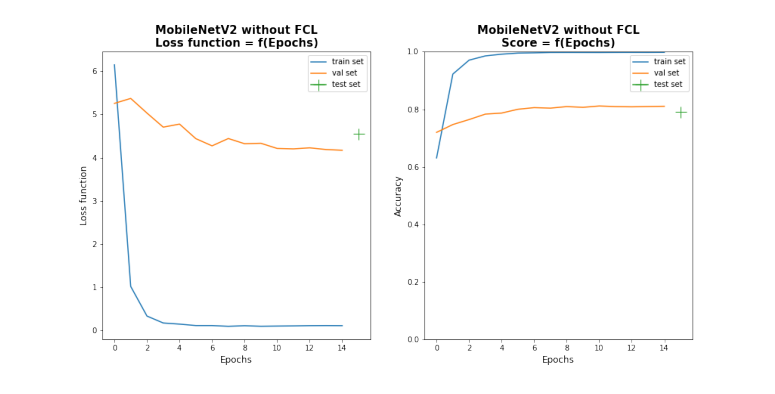

In [60]:
if (court_circuiter==False)|(court_circuiter_mobnet2_b==False):
    mobnet2_b_eval, tps_test_mobnet2_b = plot_loss_score(
        mobnet2_b_info, load_model(path_cache_output+'mobnet2_b_best.h5'), [test_ds_mobnet2], [''], 'MobileNetV2 without FCL'
    )
    if sauvegarde_figure :
        plt.savefig(path_fig+'08_mobnet2_b_plot_scores.png')
else:
    load_image_cc((14,7), path_fig, '08_mobnet2_b_plot_scores', '.png')    
#plot_loss_score(model_info=mobnet2_b_info, model_eff=load_model(path_cache_output+'mobnet2_b_best.h5'), tab_X_test=[test_ds_mobnet2], tab_label=[''], titre='MobileNetV2 without FCL')

Comme pour VGG16, le petit changement (suppression de la CCC finale originale) améliore considérablement les perfomances ! D'autant qu'avec la complexité supérieure de MobileNetV2, la précision sur le jeu de test est encore meilleure qu'avec VGG16_b, ce qui a réduit (mais pas supprimé...) le sur-apprentissage. On commence à avoir des performances décentes de prédiction !

In [61]:
if (court_circuiter==False)|(court_circuiter_mobnet2_b==False):
    dict_model(mobnet2_b_info, tps_train_mobnet2_b, mobnet2_b_eval, tps_test_mobnet2_b, 'mobnet2_b_dict')

In [62]:
if (court_circuiter==False)|(court_circuiter_mobnet2_b==False):
    del mobnet2_b, mobnet2_b_info, tps_train_mobnet2_b, mobnet2_b_eval, tps_test_mobnet2_b, layer, estop_mobnet2_b, mchkp_mobnet2_b

Nous pouvons passer donc à la construction de notre propre réseau de neurones convolutif (abrégé par la suite <i>CNN</i>). Débarassons nous entre-temps de toutes les varibales désormais inutiles.

In [63]:
del train_dataset, train_ds_mobnet2, train_size
del valid_dataset, valid_ds_mobnet2, valid_size
del test_dataset, test_ds_mobnet2, test_size

# 
# 
# <u><b>III) Construction de notre propre <i>CNN</i>.</b></u>
Nous allons nous inspirer de l'architecture de VGG16, malgré ses performances moindres, car c'est une architecture simple à appréhender pour un étudiant.

Notons que toute l'optimisation de ce réseau de neurones convolutionnel (abrégé par la suite <i>CNN</i> pour reprendre la terminologie anglo-saxonne) se fera sur un nombre réduit de races de chiens, car optimiser tant d'hyper-paramètres sur 120 races et près de 20000 images serait bien trop chronophage (et de toute façon trop demandant en calculs).

######

Il faut donc commencer par reconstituer un jeu de données réduit à une fraction des races possibles.

###### 
## <u><b>III.1) Reconstitution du jeu de données réduit à quelques races.</b></u>
###### 

Notons qu'il nous faut, en préambule de ces manoeuvres, remodifier également le <i>batch size</i>, le réduisant ainsi de moitié, toujours par soucis de soulager les capacités de calcul de l'ordinateur lors de l'optimisation. 

In [64]:
batch_size, img_height, img_width, val_split = 16, 224, 224, 0.25

### <u><b>III.1.a) Chargement des données et sélection des races.</b></u>

#### <u><b>Chargement des données.</b></u>
On commence par re-charger, comme précédemment, le <i>dataset</i> contenant toutes les races et toutes les images.

In [65]:
t0 = time()
all_dataset = image_dataset_from_directory(
    directory=path_b2d+'Images/', 
    label_mode='int',
    batch_size=None,#
    image_size=(img_height, img_width), 
    shuffle=False,
    seed=rgn
)
print(f'Dataset train re-chargé en {time()-t0 : .1f} secondes.')
del t0

Found 20580 files belonging to 120 classes.
Dataset train re-chargé en  1.2 secondes.


#### <u><b>Sélection de quelques races.</b></u>
Puis on sélectionne un nombre réduit de race, en l'occurence, 10 sur 120 possibles. La sélection se fait via l'entier de numérotation assossié à chaque race [c'est à dire selon l'ordre des races dans le dossier 'Images'], en ne retenant que les races dont cet entier est un multiple de 12.

In [66]:
# Réduction du jeu de donnée à 10 races sur 120.
few_races_dataset = all_dataset.filter(lambda x,y : y%12==0)
# Races en question
few_races = np.unique([n_idchiens[elem[1]][1] for elem in few_races_dataset.as_numpy_iterator()])
print('Les races retenues ainsi sont les suivantes :',few_races)

Les races retenues ainsi sont les suivantes : ['Chihuahua' 'German_shepherd' 'Saint_Bernard' 'Scotch_terrier'
 'Yorkshire_terrier' 'bloodhound' 'chow' 'otterhound' 'schipperke'
 'vizsla']


### <u><b>III.1.b) Séparation en jeu d'entraînement et de test.</b></u>
Ici, on reprend le procédé déjà appliqué plus haut dans ce notebook, mais en l'appliquant au <i>dataset</i> réduit à ces 10 races.

In [67]:
test_dataset = few_races_dataset.enumerate().filter(is_test).map(recover)
train_dataset = few_races_dataset.enumerate().filter(is_train).map(recover)

Pour préparer le <i>shuffling</i> de ces jeux, il nous faut calculer combien d'éléments ils comportent, on en profite donc pour s'assurer que les 10 races sont représentées dans chaque jeu.

In [68]:
elem_train = [elem[1] for elem in train_dataset.as_numpy_iterator()]
train_size, train_races = len(elem_train), np.unique(elem_train)
print(f'Le jeu d`entraînement est composé de {train_size : >5.0f} images, issues de {len(train_races)} races différentes.')
elem_test = [elem[1] for elem in test_dataset.as_numpy_iterator()]
test_size, test_races = len(elem_test), np.unique(elem_test)
print(f'Le jeu de test est composé de {test_size : >5.0f} images, issues de {len(test_races)} races différentes.')

Le jeu d`entraînement est composé de  1228 images, issues de 10 races différentes.
Le jeu de test est composé de   410 images, issues de 10 races différentes.


C'est bien le cas, on peut donc mélanger aléatoirement les éléments au sein de chacun de ces jeux (après avoir néanmoins pris le temps de se débarrasser de variables devenues entre-temps inutiles).

Notons qu'on bloque le hasard explicitement en passant comme valeur du paramètre <i>seed</i> le même entier que d'habitude.

In [69]:
del all_dataset, few_races_dataset, elem_train, elem_test

In [70]:
# Shuffle de chacun de ces deux jeux
train_dataset = train_dataset.shuffle(buffer_size=train_size, reshuffle_each_iteration=False, seed=rgn)
test_dataset = test_dataset.shuffle(buffer_size=test_size, reshuffle_each_iteration=False, seed=rgn)

### <u><b>III.1.c) Séparation en jeu d'entraînement et de validation, puis découpage des 3 jeux en <i>batch</i>.</b></u>
#### <u><b>Séparation du <i>train set</i> en un nouveau jeu d'entraînement et un jeu de validation.</b></u>
On reprend les étapes précédentes mais à partir du jeu d'entraînement déjà mélangé.

In [71]:
valid_dataset = train_dataset.enumerate().filter(is_test).map(recover)
train_dataset = train_dataset.enumerate().filter(is_train).map(recover)

On revérifie que les 10 races sont toutes représentées dans chacun de ces nouveau jeux

In [72]:
elem_train = [elem[1] for elem in train_dataset.as_numpy_iterator()]
train_size, train_races = len(elem_train), np.unique(elem_train)
print(f'Le jeu d`entraînement est composé de {train_size : >5.0f} images, issues de {len(train_races)} races différentes.')
elem_valid = [elem[1] for elem in valid_dataset.as_numpy_iterator()]
valid_size, valid_races = len(elem_valid), np.unique(elem_valid)
print(f'Le jeu de test est composé de {valid_size : >5.0f} images, issues de {len(valid_races)} races ifférentes.')

Le jeu d`entraînement est composé de   921 images, issues de 10 races différentes.
Le jeu de test est composé de   307 images, issues de 10 races ifférentes.


#### <u><b>Découpage en <i>batch</i> de ces 3 jeux.</b></u>

In [73]:
train_dataset = train_dataset.batch(batch_size=batch_size)
valid_dataset = valid_dataset.batch(batch_size=batch_size)
test_dataset = test_dataset.batch(batch_size=batch_size)

### <u><b>III.1.d) Pré-traitement des jeux de données, adaptés à une structure de type VGG16.</b></u>

In [74]:
train_ds_vgg16 = train_dataset.map(lambda x,y : (preprocin_vgg16(x),y))
valid_ds_vgg16 = valid_dataset.map(lambda x,y : (preprocin_vgg16(x),y))
test_ds_vgg16 = test_dataset.map(lambda x,y : (preprocin_vgg16(x),y))

######  
## <u><b>III.2) Construction et optimisation de notre Propre CNN sur quelques races.</b></u>

### <u><b>III.2.a) Notre CNN de base.</b></u>
On va construire un CNN de façon très simple : nous repreonnons l'architecture de VGG16, à ceci près que :
- Nous enlevons une couche de convolution 2D par bloc convolutif, afin de diminuer les temps de calculs (et en ayant à l'esprit qu'on risque de dégrader la prédiction car on identifiera moins bien de <i>features caractéristiques</i>).
- Cette base sera toujours la même, et est invoquée grâce à la fonction personelle <i>init_conv_blocks_vgg16</i>.
- On met 3 couches denses, dont la denrnière est à 120 neurones au lieu de 4096 (on met 120 et non 10 pour chercher à optimiser directement l'architecture finale du CNN, même si seulement 10 races sont à prédire pour l'instant).
- On ré-entraîne TOUTES les couches à chaque itérations.

Notons le booléen de court-circuitage local <i>court_circuiter_myCNN01</i>.

In [75]:
court_circuiter_myCNN01=True

On initialise les 5 blocs convolutifs.

In [76]:
if (court_circuiter==False)|(court_circuiter_myCNN01==False):
    myCNN01 = init_conv_blocks_vgg16(noms_layers=noms_layers_vgg16)

On rajoutes les couches denses.

In [77]:
if (court_circuiter==False)|(court_circuiter_myCNN01==False):
    myCNN01.add(Flatten())
    myCNN01.add(Dense(4096, activation='relu'))
    myCNN01.add(Dense(4096, activation='relu'))
    myCNN01.add(Dense(120, activation='softmax'))

On compile.

In [78]:
if (court_circuiter==False)|(court_circuiter_myCNN01==False):
    myCNN01.compile(loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])

On se redote d'un EarlyStoping, mais pas d'un ModelCheckpoint, car cette architecture est vouée à être longuement optimisée. Inutile donc de sauvegarder un modèle intermédiaire.

Puis on entraîne.

In [79]:
if (court_circuiter==False)|(court_circuiter_myCNN01==False):
    earl01 = EarlyStopping(verbose=1, monitor='val_sparse_categorical_accuracy', min_delta=0.025, patience=7)
    myCNN01, myCNN01_info, tps_train_01 = model_fit(
        train_ds_vgg16, X_val=valid_ds_vgg16, model_compile=myCNN01, nb_epochs=15, num_verbose=0, tab_callbacks=[earl01]
    )

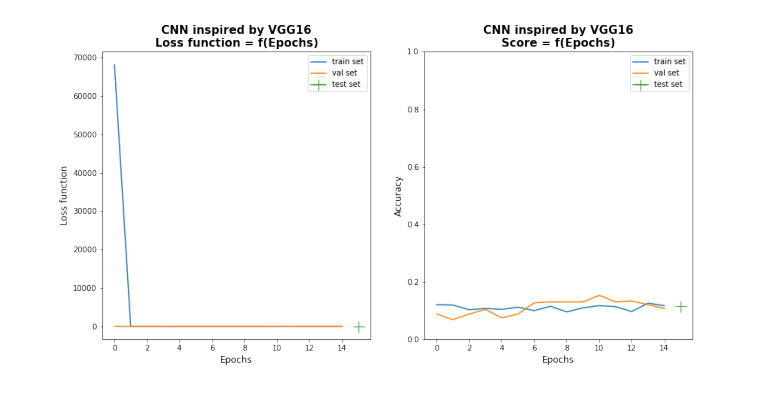

In [80]:
if (court_circuiter==False)|(court_circuiter_myCNN01==False):
    myCNN01_eval, tps_test_01 = plot_loss_score(
        myCNN01_info, myCNN01, [test_ds_vgg16], [''], 'CNN inspired by VGG16'
    )
    if sauvegarde_figure :
        plt.savefig(path_fig+'10_myCNN01_plot_scores.png')
else:
    load_image_cc((14,7), path_fig, '10_myCNN01_plot_scores', '.png')       

In [81]:
if (court_circuiter==False)|(court_circuiter_myCNN01==False):
    dict_model(myCNN01_info, tps_train_01, myCNN01_eval, tps_test_01, 'myCNN01_dict')

C'est très mauvais, à part sur le 1er pas de temps, il n'y a presque pas d'évolution des fonction de pertes, donc les courbes de précision ne progresse pas, ou très peu.

In [82]:
if (court_circuiter==False)|(court_circuiter_myCNN01==False):
    del myCNN01, myCNN01_info, tps_train_01, myCNN01_eval, tps_test_01, earl01

###### 
### <u><b>III.2.b) Optimisation du nombre et de la nature des couches.</b></u>
On va commencer l'optimisation par une mdofications du nombre et de la natures des couches en jeu.

#### <u><b>En rajoutant des couches de convolutions.</b></u>
On se dit que ces résultats exécrables peuvent venir d'un faible capacité de l'architecture à extraire des <i>features</i> caractéristiques des images, ce qui viendrait du plus faible nombre de couches convolutives que dans l'architecture originale de VGG16.

Essayons donc de rajouter un bloc convolutif entre le 5ème bloc et les coucches denses (et notons le nouveau booléen local de court-circuitage...)

In [83]:
court_circuiter_myCNN02=True

In [84]:
if (court_circuiter==False)|(court_circuiter_myCNN02==False):
    myCNN02 = init_conv_blocks_vgg16(noms_layers=noms_layers_vgg16)

In [85]:
if (court_circuiter==False)|(court_circuiter_myCNN02==False):
    # Rajout d'un 6ème bloc convolutif
    myCNN02.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    myCNN02.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    myCNN02.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    # Couches denses
    myCNN02.add(Flatten())
    myCNN02.add(Dense(4096, activation='relu'))
    myCNN02.add(Dense(4096, activation='relu'))
    myCNN02.add(Dense(120, activation='softmax'))

In [86]:
if (court_circuiter==False)|(court_circuiter_myCNN02==False):
    myCNN02.compile(loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])
    earl02 = EarlyStopping(verbose=1, monitor='val_sparse_categorical_accuracy', min_delta=0.025, patience=7)
    myCNN02, myCNN02_info, tps_train_02 = model_fit(
        train_ds_vgg16, X_val=valid_ds_vgg16, model_compile=myCNN02, nb_epochs=15, num_verbose=0, tab_callbacks=[earl02]
    )

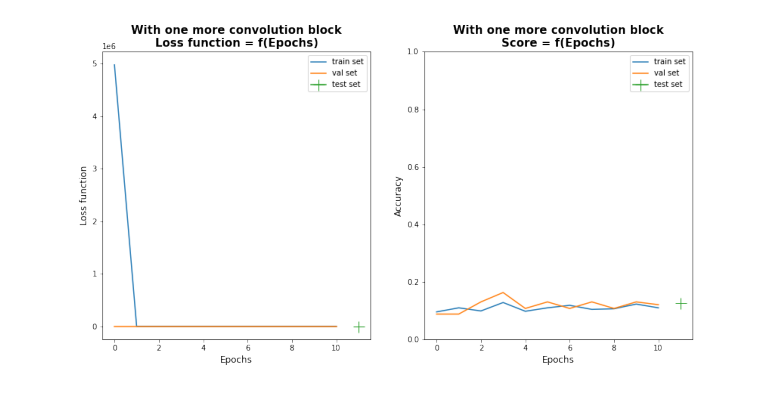

In [87]:
if (court_circuiter==False)|(court_circuiter_myCNN02==False):
    myCNN02_eval, tps_test_02 = plot_loss_score(
        myCNN02_info, myCNN02, [test_ds_vgg16], [''], 'With one more convolution block'
    )
    if sauvegarde_figure :
        plt.savefig(path_fig+'10_myCNN02_plot_scores.png')
else :
    load_image_cc((14,7), path_fig, '10_myCNN02_plot_scores', '.png')

Pas mieux, ça n'a quasiment rien changé à nos performances... Cela peut signifier que les features extraites ne peuvent pas être améliorées par ce 6ème bloc convolutif, car dès le départ (1ere et 2nd blocs) les formes reconnues sont trop peu nombreuses/trop peu complexes.

In [88]:
if (court_circuiter==False)|(court_circuiter_myCNN02==False):
    dict_model(myCNN02_info, tps_train_02, myCNN02_eval, tps_test_02, 'myCNN02_dict')

In [89]:
if (court_circuiter==False)|(court_circuiter_myCNN02==False):
    del myCNN02, myCNN02_info, tps_train_02, myCNN02_eval, tps_test_02, earl02

#### <u><b>En rajoutant des couches denses.</b></u>
Essayons alors, à défaut d'améliorer les <i>features</i> extraites, de mieux les attrribuer à chaque race : rajoutons deux couches denses dans le bloc de couches CCC.

In [91]:
court_circuiter_myCNN03=False

In [90]:
if (court_circuiter==False)|(court_circuiter_myCNN02==False):
    myCNN03 = init_conv_blocks_vgg16(noms_layers=noms_layers_vgg16)
    #### 
    myCNN03.add(Flatten())
    myCNN03.add(Dense(4096, activation='relu'))
    myCNN03.add(Dense(4096, activation='relu'))
    myCNN03.add(Dense(4096, activation='relu'))
    myCNN03.add(Dense(4096, activation='relu'))
    myCNN03.add(Dense(120, activation='softmax'))
    ###
    myCNN03.compile(loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])
    earl03 = EarlyStopping(verbose=1, monitor='val_sparse_categorical_accuracy', min_delta=0.025, patience=7)
    myCNN03, myCNN03_info, tps_train_03 = model_fit(
        train_ds_vgg16, X_val=valid_ds_vgg16, model_compile=myCNN03, nb_epochs=15, num_verbose=0, tab_callbacks=[earl03]
    )

Epoch 11: early stopping
Temps d`entraînement : 218.2 secondes


26/26 [==============================] - 7s 50ms/step - loss: 2.3004 - sparse_categorical_accuracy: 0.1146
Temps d`évaluation : 7.2 secondes


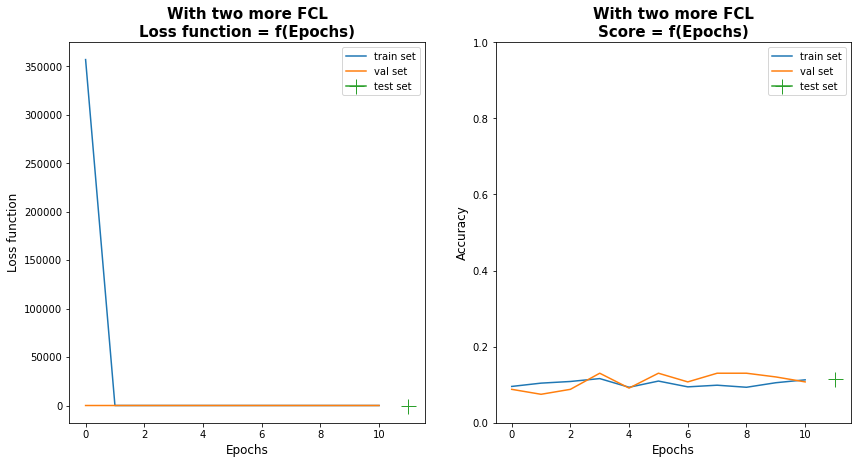

In [92]:
if (court_circuiter==False)|(court_circuiter_myCNN03==False):
    myCNN03_eval, tps_test_03 = plot_loss_score(
        myCNN03_info, myCNN03, [test_ds_vgg16], [''], 'With two more FCL'
    )
    if sauvegarde_figure :
        plt.savefig(path_fig+'10_myCNN03_plot_scores.png')
else :
    load_image_cc((14,7), path_fig, '10_myCNN03_plot_scores', '.png')

Toujours pas mieux...

In [93]:
if (court_circuiter==False)|(court_circuiter_myCNN03==False):
    dict_model(myCNN03_info, tps_train_03, myCNN03_eval, tps_test_03, 'myCNN03_dict')

On vient de montrer que ni l'apprentissage ni le test ne se sont améliorés en rajoutant des couches de convolution ou des couches denses finales. Il faut essayer autre chose.

In [94]:
if (court_circuiter==False)|(court_circuiter_myCNN03==False):
    del myCNN03, myCNN03_info, tps_train_03, myCNN03_eval, tps_test_03, earl03

###### 
### <u><b>III.2.c) Optimisation de l'algorithme de descente de gradient.</b></u>
L'idée nous est venue du fait de la platitude des courbes de précisions précédentes : et si nous étions dès les 1ères itérations bloqués dans un minimum local de la fonction de perte ?

Essayons d'autres algo de descente de gradient que celui implémenté par défaut dans les objets de types Sequential lors du fit [qui est <i>RMSprop</i>].

#### <u><b>ADAM.</b></u>
On commence par l'algo de type ADAM, qui semble être assez prisé par la communauté d'étudient OC sur Discord. 

Notons que pour aller plus vite en terme de longueur de notebooke, on condense le plus de cellules possibles.

In [95]:
court_circuiter_myCNN11=False

In [97]:
if (court_circuiter==False)|(court_circuiter_myCNN11==False):
    myCNN11 = init_conv_blocks_vgg16(noms_layers=noms_layers_vgg16)
    myCNN11.add(Flatten())
    myCNN11.add(Dense(4096, activation='relu'))
    myCNN11.add(Dense(4096, activation='relu'))
    myCNN11.add(Dense(120, activation='softmax'))
    # Adam est précisé dans l'hyper-paramètre 'optimizer' lors de la compilation
    myCNN11.compile(loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"], optimizer='adam')
    earl11 = EarlyStopping(verbose=1, monitor='val_sparse_categorical_accuracy', min_delta=0.025, patience=7)
    myCNN11, myCNN11_info, tps_train_11 = model_fit(
        train_ds_vgg16, X_val=valid_ds_vgg16, model_compile=myCNN11, nb_epochs=15, num_verbose=0, tab_callbacks=[earl11]
    )

Epoch 8: early stopping
Temps d`entraînement : 134.8 secondes


26/26 [==============================] - 6s 30ms/step - loss: 2.3123 - sparse_categorical_accuracy: 0.0927
Temps d`évaluation : 6.4 secondes


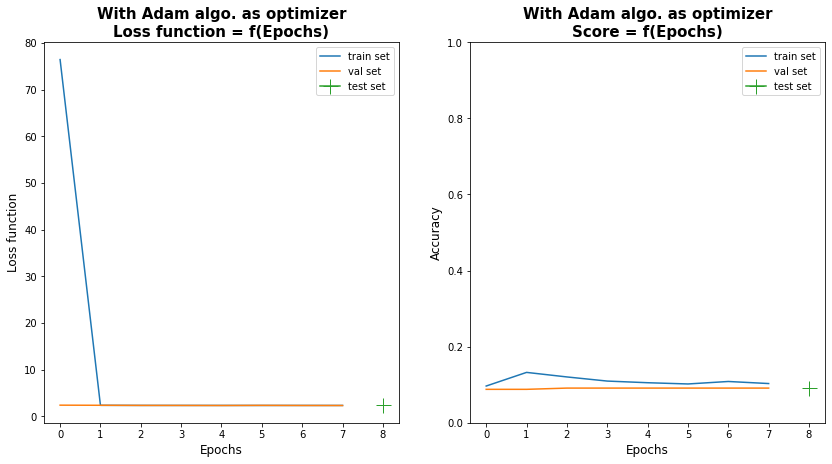

In [98]:
if (court_circuiter==False)|(court_circuiter_myCNN11==False):
    myCNN11_eval, tps_test_11 = plot_loss_score(
        myCNN11_info, myCNN11, [test_ds_vgg16], [''], 'With Adam algo. as optimizer'
    )
    if sauvegarde_figure :
        plt.savefig(path_fig+'10_myCNN11_plot_scores.png')
else :
    load_image_cc((14,7), path_fig, '10_myCNN11_plot_scores', '.png')

Malgré une nette amélioration de la valeur intiale de la fonction de perte, ce n'est pas suffisant pour faire décoler les courbes de précisions?

In [99]:
if (court_circuiter==False)|(court_circuiter_myCNN11==False):
    dict_model(myCNN11_info, tps_train_11, myCNN11_eval, tps_test_11, 'myCNN11_dict')

In [100]:
if (court_circuiter==False)|(court_circuiter_myCNN11==False):
    del myCNN11, myCNN11_info, tps_train_11, myCNN11_eval, tps_test_11, earl11

#### <u><b>SGD.</b></u>
Après ADAM, essayons SGD...

In [101]:
court_circuiter_myCNN12=False

In [102]:
if (court_circuiter==False)|(court_circuiter_myCNN12==False):
    myCNN12 = init_conv_blocks_vgg16(noms_layers=noms_layers_vgg16)
    myCNN12.add(Flatten())
    myCNN12.add(Dense(4096, activation='relu'))
    myCNN12.add(Dense(4096, activation='relu'))
    myCNN12.add(Dense(120, activation='softmax'))
    # SGD est précisé dans l'hyper-paramètre 'optimizer' lors de la compilation
    myCNN12.compile(loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"], optimizer='SGD')
    earl12 = EarlyStopping(verbose=1, monitor='val_sparse_categorical_accuracy', min_delta=0.025, patience=10)
    myCNN12, myCNN12_info, tps_train_12 = model_fit(
        train_ds_vgg16, X_val=valid_ds_vgg16, model_compile=myCNN12, nb_epochs=25, num_verbose=0, tab_callbacks=[earl12]
    )

Epoch 19: early stopping
Temps d`entraînement : 320.7 secondes


26/26 [==============================] - 7s 36ms/step - loss: 4.6007 - sparse_categorical_accuracy: 0.2878
Temps d`évaluation : 6.8 secondes


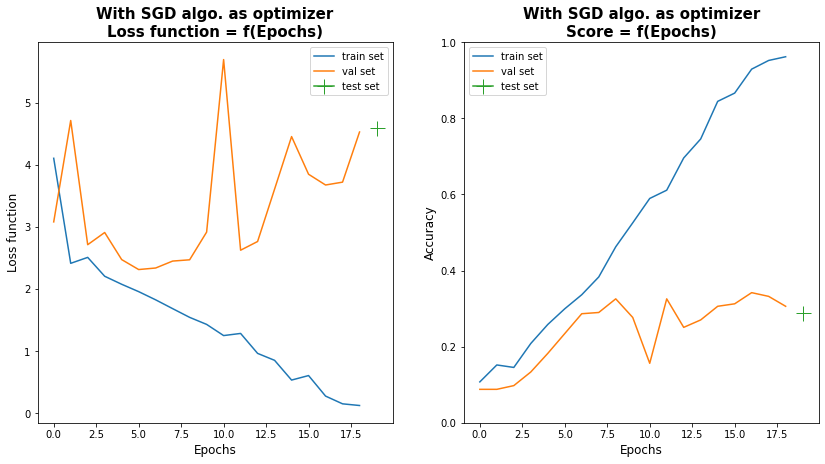

In [103]:
if (court_circuiter==False)|(court_circuiter_myCNN12==False):
    myCNN12_eval, tps_test_12 = plot_loss_score(
        myCNN12_info, myCNN12, [test_ds_vgg16], [''], 'With SGD algo. as optimizer'
    )
    if sauvegarde_figure :
        plt.savefig(path_fig+'10_myCNN12_plot_scores.png')
else :
    load_image_cc((14,7), path_fig, '10_myCNN12_plot_scores', '.png')

AH ! ENFIN ! La précision devient enfin signifiactive sur les trois jeux (avec pas mal de sur-apprentissage passée la 8ème iterration toutefois).

Notons que sur un lancement du notebook précédent, on voyait des fluctuation importantes dans la courbe d'apprentissage, lors des 10 dernières iterrations, ce qui nous a fait penser qu'on était peut être en train de 'tourner' autour d'un minimum local à cause d'un <i>learning rate</i> mal adapté. Ca n'apparaît peut être pas cette fois, car tout le hasard n'est pas complètement figé lorsqu'on lance des modèles de <i>deep learning</i> (répartition des tâches entre GPU aléatoire).

En tout cas, il faut garder ça à l'esprit pour comprendre la suite.

In [106]:
if (court_circuiter==False)|(court_circuiter_myCNN12==False):
    dict_model(myCNN12_info, tps_train_12, myCNN12_eval, tps_test_12, 'myCNN12_dict')

In [107]:
if (court_circuiter==False)|(court_circuiter_myCNN12==False):
    del myCNN12, myCNN12_info, tps_train_12, myCNN12_eval, tps_test_12, earl12

###### 
### <u><b>III.2.d) SGD avec adaptation du <i>learning rate</i>.</b></u>
Sur un lancement précédent du notebook, on voyait des fluctuation importantes dans la courbe d'apprentissage avec l'algo SGD, lors des 10 dernières iterrations, ce qui nous a fait penser qu'on était peut être en train de 'tourner' autour d'un minimum local à cause d'un learning rate mal adapté.

On utilise donc un <i>ReduceLROnPlateau</i> pour diminuer le <i>learning rate</i> (division par 10) quand la précision sur le jeu de validation ne progresse plus.

In [108]:
court_circuiter_myCNN12_=False

In [110]:
if (court_circuiter==False)|(court_circuiter_myCNN12_==False):
    from tensorflow.keras.callbacks import ReduceLROnPlateau
    myCNN12 = init_conv_blocks_vgg16(noms_layers=noms_layers_vgg16)
    myCNN12.add(Flatten())
    myCNN12.add(Dense(4096, activation='relu'))
    myCNN12.add(Dense(4096, activation='relu'))
    myCNN12.add(Dense(120, activation='softmax'))
    myCNN12.compile(loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"], optimizer='SGD')
    earl12 = EarlyStopping(verbose=1, monitor='val_sparse_categorical_accuracy', min_delta=0.025, patience=10)
    redonplat12 = ReduceLROnPlateau(verbose=1, monitor='val_sparse_categorical_accuracy', min_delta=0.025, patience=5)
    myCNN12, myCNN12_info, tps_train_12 = model_fit(
        train_ds_vgg16, X_val=valid_ds_vgg16, model_compile=myCNN12, nb_epochs=25, num_verbose=0, tab_callbacks=[earl12, redonplat12]
    )


Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 22: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.
Epoch 22: early stopping
Temps d`entraînement : 378.6 secondes


26/26 [==============================] - 7s 35ms/step - loss: 3.8313 - sparse_categorical_accuracy: 0.3171
Temps d`évaluation : 6.8 secondes


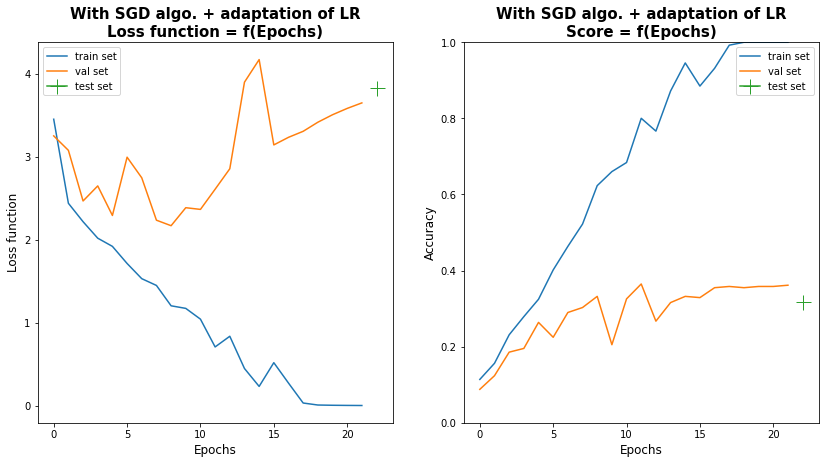

In [111]:
if (court_circuiter==False)|(court_circuiter_myCNN12_==False):
    myCNN12_eval, tps_test_12 = plot_loss_score(
        myCNN12_info, myCNN12, [test_ds_vgg16], [''], 'With SGD algo. + adaptation of LR'
    )
    if sauvegarde_figure :
        plt.savefig(path_fig+'11_myCNN12_plot_scores.png')
else :
    load_image_cc((14,7), path_fig, '11_myCNN12_plot_scores', '.png')

C'est un peu mieux, notamment lors des dernières iterrations, avec un score sur jeu de test qui a pris +2.5-3% (ce qui n'est pas énorme, mais pas négligeable).

Très gros sur-apprentissage néanmoins.

In [112]:
if (court_circuiter==False)|(court_circuiter_myCNN12_==False):
    dict_model(myCNN12_info, tps_train_12, myCNN12_eval, tps_test_12, 'myCNN12__dict')

In [113]:
if (court_circuiter==False)|(court_circuiter_myCNN12_==False):
    del myCNN12, myCNN12_info, tps_train_12, myCNN12_eval, tps_test_12, earl12, redonplat12

###### 
### <u><b>III.2.e) Lutte contre le sur-apprentissage.</b></u>
On rajoute quelques couches de <i>Dropout</i> entre chaque couche dense pour tenter de diminuer le surapprentissage, avec un taux de dropout rate relativement important de 0.5.

In [114]:
court_circuiter_myCNN21=False

In [115]:
if (court_circuiter==False)|(court_circuiter_myCNN21==False):
    myCNN21 = init_conv_blocks_vgg16(noms_layers=noms_layers_vgg16)
    myCNN21.add(Flatten())
    myCNN21.add(Dense(4096, activation='relu'))
    myCNN21.add(Dropout(rate=0.5, seed=rgn))
    myCNN21.add(Dense(4096, activation='relu'))
    myCNN21.add(Dropout(rate=0.5, seed=rgn))
    myCNN21.add(Dense(120, activation='softmax'))
    myCNN21.compile(loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"], optimizer='SGD')
    earl21 = EarlyStopping(verbose=1, monitor='val_sparse_categorical_accuracy', min_delta=0.025, patience=10)
    redonplat21 = ReduceLROnPlateau(verbose=1, monitor='val_sparse_categorical_accuracy', min_delta=0.025, patience=5)
    myCNN21, myCNN21_info, tps_train_21 = model_fit(
        train_ds_vgg16, X_val=valid_ds_vgg16, model_compile=myCNN21, nb_epochs=25, num_verbose=0, tab_callbacks=[earl21, redonplat21]
    )


Epoch 20: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 25: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.
Epoch 25: early stopping
Temps d`entraînement : 422.2 secondes


26/26 [==============================] - 7s 31ms/step - loss: 2.9391 - sparse_categorical_accuracy: 0.3317
Temps d`évaluation : 6.7 secondes


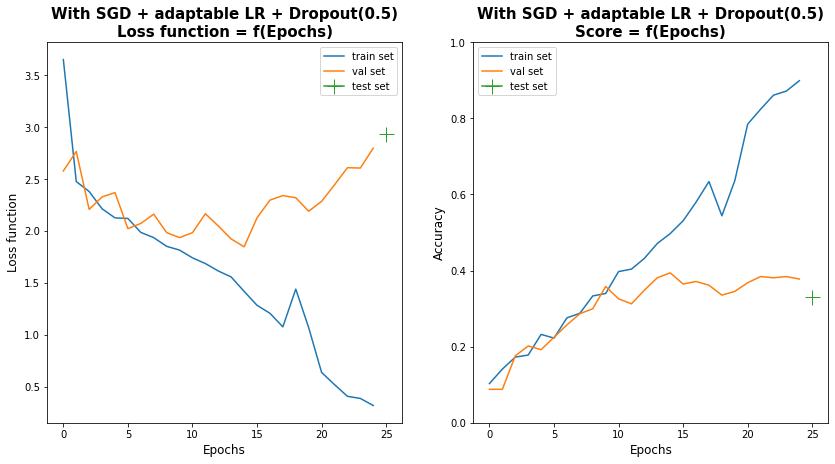

In [116]:
if (court_circuiter==False)|(court_circuiter_myCNN21==False):
    myCNN21_eval, tps_test_21 = plot_loss_score(
        myCNN21_info, myCNN21, [test_ds_vgg16], [''], 'With SGD + adaptable LR + Dropout(0.5)'
    )
    if sauvegarde_figure :
        plt.savefig(path_fig+'11_myCNN21_plot_scores.png')
else :
    load_image_cc((14,7), path_fig, '11_myCNN21_plot_scores', '.png')

Résultat : Le sur-apprentissage a un peu diminué, tant par la courbe d'apprentissage moins haute que par les courbes de validation et l'évaluation sur le jeu de test, qui ont encore un peu progressé de quelques pourcents.

In [118]:
if (court_circuiter==False)|(court_circuiter_myCNN21==False):
    dict_model(myCNN21_info, tps_train_21, myCNN21_eval, tps_test_21, 'myCNN21_dict')

In [121]:
if (court_circuiter==False)|(court_circuiter_myCNN21==False):
    del myCNN21, myCNN21_info, tps_train_21, myCNN21_eval, tps_test_21, earl21, redonplat21, redonplat12

###### 
Bien, on ne cherche pas à augmenter encore le <i>droupout rate</i>, car on en était déjà à supprimer une conenxion sur deux aléatoirement, ça n'aurait plus beaucoup de sens. On se résigne donc à ce sur-apprentissage important.

On va donc conserver le réseau en l'état, et passer à l'entraînement sur 120 races d'un coup...

In [122]:
del few_races
del train_dataset, train_ds_vgg16, train_races, train_size
del valid_dataset, valid_ds_vgg16, valid_races, valid_size
del test_dataset, test_ds_vgg16, test_races, test_size

######  
## <u><b>III.3) CNN final sur toutes les races.</b></u>

###### 
### <u><b>III.3.a) Re-création d'un jeu de données à 120 races.</b></u>
On doit re-créer un jeu de données, de façon similaire à ce qu'on avait fait pour le transfert learning avec VGG16.

In [123]:
t0 = time()
all_dataset = image_dataset_from_directory(
    directory=path_b2d+'Images/', 
    label_mode='int',
    batch_size=None,#
    image_size=(img_height, img_width), 
    shuffle=False,
    seed=rgn
)
print(f'Dataset train chargé en {time()-t0 : .1f} secondes.')
del t0

Found 20580 files belonging to 120 classes.
Dataset train chargé en  1.3 secondes.


In [124]:
test_dataset = all_dataset.enumerate().filter(is_test).map(recover)
train_dataset = all_dataset.enumerate().filter(is_train).map(recover)

In [125]:
elem_train = [elem[1] for elem in train_dataset.as_numpy_iterator()]
train_size, train_races = len(elem_train), np.unique(elem_train)
print(f'Le jeu d`entraînement est composé de {train_size : >5.0f} images, issues de {len(train_races)} races différentes.')
elem_test = [elem[1] for elem in test_dataset.as_numpy_iterator()]
test_size, test_races = len(elem_test), np.unique(elem_test)
print(f'Le jeu de test est composé de {test_size : >5.0f} images, issues de {len(test_races)} races différentes.')

Le jeu d`entraînement est composé de 15435 images, issues de 120 races différentes.
Le jeu de test est composé de  5145 images, issues de 120 races différentes.


In [126]:
train_dataset = train_dataset.shuffle(buffer_size=train_size, reshuffle_each_iteration=False, seed=rgn)
test_dataset = test_dataset.shuffle(buffer_size=test_size, reshuffle_each_iteration=False, seed=rgn)

In [127]:
valid_dataset = train_dataset.enumerate().filter(is_test).map(recover)
train_dataset = train_dataset.enumerate().filter(is_train).map(recover)

In [128]:
elem_train = [elem[1] for elem in train_dataset.as_numpy_iterator()]
train_size, train_races = len(elem_train), np.unique(elem_train)
print(f'Le jeu d`entraînement est composé de {train_size : >5.0f} images, issues de {len(train_races)} races différentes.')
elem_valid = [elem[1] for elem in valid_dataset.as_numpy_iterator()]
valid_size, valid_races = len(elem_valid), np.unique(elem_valid)
print(f'Le jeu de test est composé de {valid_size : >5.0f} images, issues de {len(valid_races)} races ifférentes.')

Le jeu d`entraînement est composé de 11576 images, issues de 120 races différentes.
Le jeu de test est composé de  3859 images, issues de 120 races ifférentes.


In [129]:
train_dataset = train_dataset.batch(batch_size=batch_size)
valid_dataset = valid_dataset.batch(batch_size=batch_size)
test_dataset = test_dataset.batch(batch_size=batch_size)

In [130]:
train_ds_vgg16 = train_dataset.map(lambda x,y : (preprocin_vgg16(x),y))
valid_ds_vgg16 = valid_dataset.map(lambda x,y : (preprocin_vgg16(x),y))
test_ds_vgg16 = test_dataset.map(lambda x,y : (preprocin_vgg16(x),y))

In [131]:
del train_dataset, valid_dataset, test_dataset
del elem_train, elem_valid, elem_test

###### 
### <u><b>III.3.b) Re-entraînement sur 120 races.</b></u>
On reprend la dernière architecture, mais en entraînant cette fois sur le nouveau jeu de données à 120 races.

In [132]:
court_circuiter_myCNN30=False

In [134]:
if (court_circuiter==False)|(court_circuiter_myCNN30==False):
    myCNN30 = init_conv_blocks_vgg16(noms_layers=noms_layers_vgg16)
    myCNN30.add(Flatten())
    myCNN30.add(Dense(4096, activation='relu'))
    myCNN30.add(Dropout(rate=0.5, seed=rgn))
    myCNN30.add(Dense(4096, activation='relu'))
    myCNN30.add(Dropout(rate=0.5, seed=rgn))
    myCNN30.add(Dense(120, activation='softmax'))
    myCNN30.compile(loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"], optimizer='SGD')
    earl30 = EarlyStopping(verbose=1, monitor='val_sparse_categorical_accuracy', min_delta=0.025, patience=10)
    redonplat30 = ReduceLROnPlateau(verbose=1, monitor='val_sparse_categorical_accuracy', min_delta=0.025, patience=5)
    myCNN30, myCNN30_info, tps_train_30 = model_fit(
        train_ds_vgg16, X_val=valid_ds_vgg16, model_compile=myCNN30, nb_epochs=25, num_verbose=2, tab_callbacks=[earl30, redonplat30]
    )

Epoch 1/25
724/724 - 80s - loss: 4.8034 - sparse_categorical_accuracy: 0.0089 - val_loss: 4.7859 - val_sparse_categorical_accuracy: 0.0114 - lr: 0.0100 - 80s/epoch - 111ms/step
Epoch 2/25
724/724 - 81s - loss: 4.7812 - sparse_categorical_accuracy: 0.0111 - val_loss: 4.7762 - val_sparse_categorical_accuracy: 0.0114 - lr: 0.0100 - 81s/epoch - 112ms/step
Epoch 3/25
724/724 - 82s - loss: 4.7453 - sparse_categorical_accuracy: 0.0186 - val_loss: 4.6525 - val_sparse_categorical_accuracy: 0.0272 - lr: 0.0100 - 82s/epoch - 114ms/step
Epoch 4/25
724/724 - 83s - loss: 4.6154 - sparse_categorical_accuracy: 0.0243 - val_loss: 4.5061 - val_sparse_categorical_accuracy: 0.0280 - lr: 0.0100 - 83s/epoch - 115ms/step
Epoch 5/25
724/724 - 84s - loss: 4.4822 - sparse_categorical_accuracy: 0.0349 - val_loss: 4.4186 - val_sparse_categorical_accuracy: 0.0384 - lr: 0.0100 - 84s/epoch - 116ms/step
Epoch 6/25
724/724 - 85s - loss: 4.3759 - sparse_categorical_accuracy: 0.0445 - val_loss: 4.3372 - val_sparse_categ

322/322 [==============================] - 18s 31ms/step - loss: 5.8487 - sparse_categorical_accuracy: 0.1380
Temps d`évaluation : 18.4 secondes


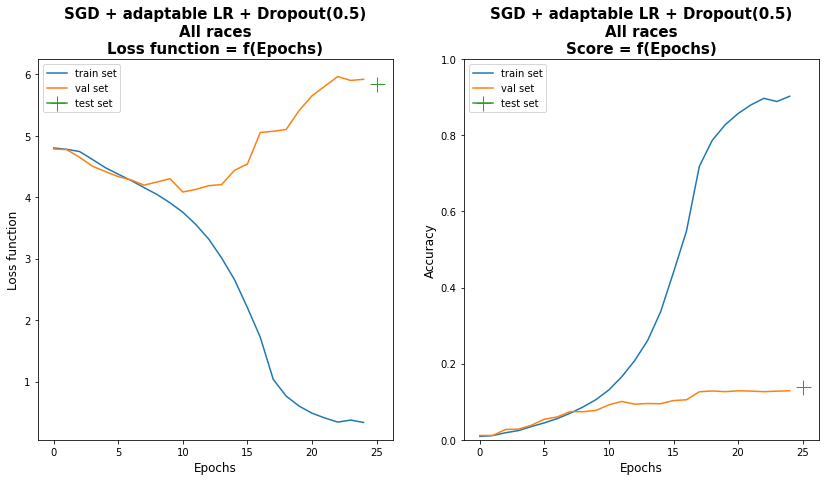

In [135]:
if (court_circuiter==False)|(court_circuiter_myCNN30==False):
    myCNN30_eval, tps_test_30 = plot_loss_score(
        myCNN30_info, myCNN30, [test_ds_vgg16], [''], 'SGD + adaptable LR + Dropout(0.5)\nAll races'
    )
    if sauvegarde_figure :
        plt.savefig(path_fig+'11_myCNN30_plot_scores.png')
else :
    load_image_cc((14,7), path_fig, '11_myCNN30_plot_scores', '.png')

Enorme sur-apprentissage à patrir de la 8ème iterration, et faible progression de la courbe de précision sur le jeuy de validation (malgré une fonction de perte sur le même jeu qui était en hausse, ce qui est assez remarquable pour être souligné).

On s'attendait à ne pas pouvoir ne serait-ce qu'approcher les performances avec transfert learning, mais c'est quand même décevant...

In [136]:
if (court_circuiter==False)|(court_circuiter_myCNN30==False):
    dict_model(myCNN30_info, tps_train_30, myCNN30_eval, tps_test_30, 'myCNN30_dict')

In [137]:
if (court_circuiter==False)|(court_circuiter_myCNN30==False):
    del myCNN30, myCNN30_info, tps_train_30, myCNN30_eval, tps_test_30

# 
# 
# <u><b>IV) Model final sélectionné.</b></u>

######  
## <u><b>IV.1) Comparaison des modèles.</b></u>
Bien que la différence de résultats puisse sauter aux yeux, prennons le temps de faire la comparaison entre les différents modèles de <i>transfert learning</i> et notre propre CNN.

In [161]:
# Liste des noms sous lesquels sont enregistrés les modèles
tab_model = ['vgg16_a', 'vgg16_b', 'mobnet2_a', 'mobnet2_b', 'myCNN30']
# Liste des dictionnaires de performances correspondant
tab_dict = [
    pickle_load(suffix_title=name+'_dict') for name in tab_model
]

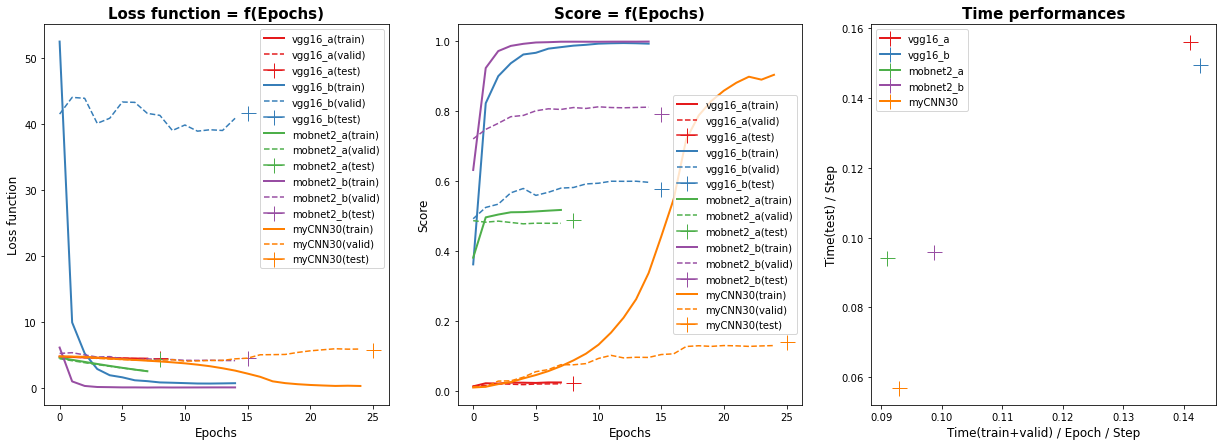

In [179]:
plt.figure('Comparaisons performances', figsize=(21,7)), plt.clf()
axe1, axe2, axe3, metric = plt.subplot(1,3,1), plt.subplot(1,3,2), plt.subplot(1,3,3), 'sparse_categorical_accuracy'
# Loss function = f(epochs)
axe1.set_title('Loss function = f(Epochs)', fontsize=15, fontweight='bold'), axe1.set_ylabel('Loss function', fontsize=12), axe1.set_xlabel('Epochs', fontsize=12)
for i, (name, dic) in enumerate(zip(tab_model, tab_dict)) :
    c = cm.Set1(i)
    axe1.plot(dic['loss'], linewidth=2, label=name+'(train)', color=c)
    axe1.plot(dic['val_loss'], linestyle='--', label=name+'(valid)', color=c)
    axe1.plot([len(dic['loss'])], [dic['test_loss']], label=name+'(test)', color=c, marker='+', markersize=15)
# Score = f(epochs)
axe2.set_title('Score = f(Epochs)', fontsize=15, fontweight='bold'), axe2.set_ylabel('Score', fontsize=12), axe2.set_xlabel('Epochs', fontsize=12)
for i, (name, dic) in enumerate(zip(tab_model, tab_dict)) :
    c = cm.Set1(i)
    axe2.plot(dic[metric], linewidth=2, label=name+'(train)', color=c)
    axe2.plot(dic['val_'+metric], linestyle='--', label=name+'(valid)', color=c)
    axe2.plot([len(dic['loss'])], [dic['test_'+metric]], label=name+'(test)', color=c, marker='+', markersize=15)
# Score = f(epochs)
axe3.set_title('Time performances', fontsize=15, fontweight='bold'), axe3.set_ylabel('Time(test) / Step', fontsize=12), axe3.set_xlabel('Time(train+valid) / Epoch / Step', fontsize=12)
for i, (name, dic) in enumerate(zip(tab_model, tab_dict)) :
    c = cm.Set1(i)
    b_size = 16 if name==tab_model[-1] else 32
    axe3.plot([dic['train_time']/len(dic['loss'])/((train_size+valid_size)/b_size)], [dic['test_time']/(test_size/b_size)], linewidth=2, label=name, color=c, marker='+', markersize=15)
# Legends
axe1.legend(loc='best'), axe2.legend(loc='best'), axe3.legend(loc='best')
if sauvegarde_figure:
    plt.savefig(path_fig+'12_comparaison_modeles.png')
del axe1, axe2, axe3, metric, i, name, dic, c, b_size

En terme de performances "pures" (valeurs finales des fonctions de perte, et des scores de précision sur les trois jeux de données), c'est "mobnet2_b" qui est le meilleur modèle de loin.

En terme de performances temporelles, ce n'est pas le meilleur. On a même la surprise de voir que notre CNN personnel est le plus rapide par itération et/ou par pas d'exécution. Cette surprise doit néanmoins être nuancée par le fait que notre CNN comporte bien moins de couches convolutionnelles en son sein que VGG16 (dont il s'inspire) et MobileNetV2 (dont les couches convolutionnelles sont de type <i>depth wise</i>, soit des convolutions faites en distinguant chaque canal de couleur, ce qui est encore plus lourd en terme de complexité de calculs). En regard de cette remarque, on peut re-considérer les écarts de performances temporelles comme finalement peu significatives. 

Notre meilleur modèle est donc sans aucun doute possible "mobnet2_b".

######  
## <u><b>IV.2) Analyse des prédiction du modèle sélectionné.</b></u>
Pour cela, on a besoin seulement d'un jeu de test pré-traité, mais il faut donc quand même repasser par uen regénération d'un jeu de données...

###### 
### <u><b>IV.2.a) Régénerer un jeu de test adapté à notre modèle.</b></u>

In [245]:
t0 = time()
all_dataset = image_dataset_from_directory(
    directory=path_b2d+'Images/', 
    label_mode='int',
    batch_size=None,#
    image_size=(img_height, img_width), 
    shuffle=False,
    seed=rgn
)
print(f'Dataset train chargé en {time()-t0 : .1f} secondes.')
del t0

Found 20580 files belonging to 120 classes.
Dataset train chargé en  1.2 secondes.


In [247]:
tab_files_path = np.array(all_dataset.file_paths)

In [195]:
test_dataset = all_dataset.enumerate().filter(is_test).map(recover)

In [196]:
elem_test = [elem[1] for elem in test_dataset.as_numpy_iterator()]
test_size, test_races = len(elem_test), np.unique(elem_test)
print(f'Le jeu de test est composé de {test_size : >5.0f} images, issues de {len(test_races)} races différentes.')

Le jeu de test est composé de  5145 images, issues de 120 races différentes.


In [197]:
test_dataset = test_dataset.shuffle(buffer_size=test_size, reshuffle_each_iteration=False, seed=rgn)

In [198]:
test_dataset = test_dataset.batch(batch_size=32)

In [199]:
test_ds_mobnet2 = test_dataset.map(lambda x,y : (preprocin_mobnet2(x),y))

In [200]:
del all_dataset, elem_test

###### 
### <u><b>IV.2.b) Matrice de confusion adaptée à 120 races.</b></u>
Bien, affichons la matrice des probabilités moyenne de prédiction par race, et pour chaque race étiquette (c'estr à dire pour chaque VRAIE race)

In [201]:
races = np.array([val[1] for val in n_idchiens.values()])

In [202]:
y_test = np.concatenate([[races[n] for n in elem[1]] for elem in test_ds_mobnet2.as_numpy_iterator()])

In [203]:
best_model = load_model(path_cache_output+'mobnet2_b_best.h5')

In [204]:
pred = best_model.predict(x=test_ds_mobnet2)

161/161 [==============================] - 15s 36ms/step


In [205]:
# Initialisation des dictionnaires qui enregistreront les proba de prédiction par étiquette
dico_pred = {'Vraie race':y_test}

In [206]:
# Construction de ce dictionnaire, clef=race étiquette, valeur=probabilité de prédiction par race
for n in range(120):
    dico_pred[races[n]] = pred[:,n]

In [208]:
# Liste des Dataframes de proba(y_pred) = f(y_true)
df_pred = pd.DataFrame(data=dico_pred)

In [213]:
# Matrice des probabilité moyenne de prédiction entre races
mat_pred = df_pred.groupby('Vraie race').describe()[[(race, 'mean') for race in np.sort(races)]]

Ci dessous :
- lignes = vraies races, étiquettes
- colonnes = races possibles, classes de pérdiction
- valeur = probabilité moyenne (sur l'ensemble des images de la race étiquette) de prédiction de la race en colonne

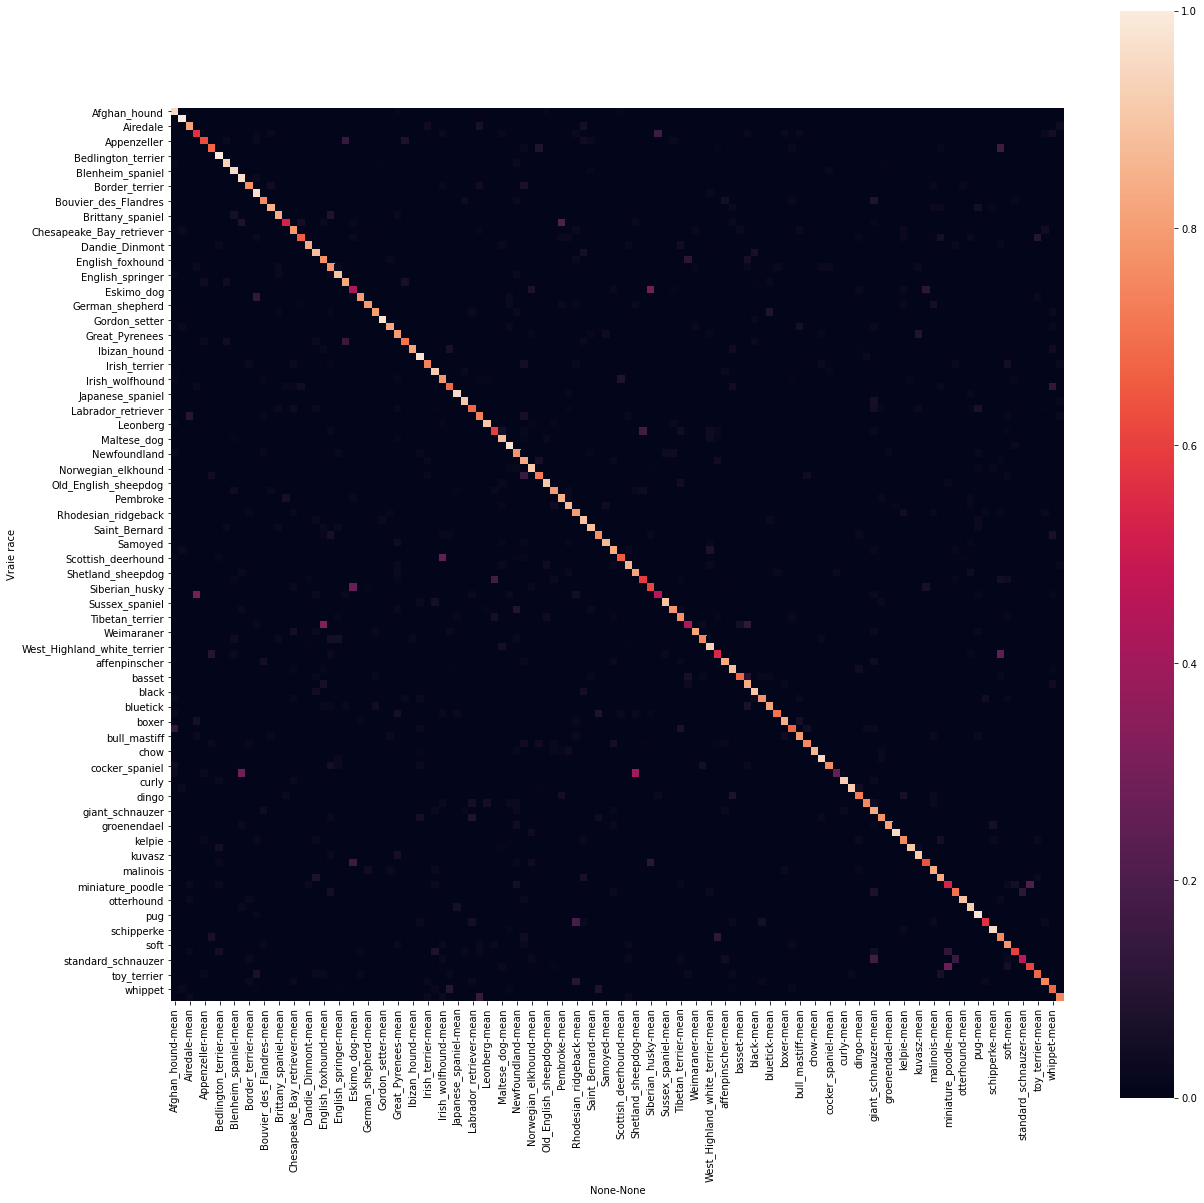

In [216]:
### Représentation graphique
plt.figure('Matrice de confusion adaptée à 120 races ', figsize=(20,20)), plt.clf()
axe = plt.subplot(111)
heatmap(data=mat_pred, ax=axe, square=True, annot=False, vmin=0, vmax=1)
if sauvegarde_figure:
    plt.savefig(path_fig+'12_mobnet2_b_confusion_matrix.png')
del axe

On voit grâce à la diagonale que la plupart des races sont assez bien prédites (coefficient diagonal bien supérieur à 50%), et que lorsque des mauvaises races sont prédites, c'est un très petit nombre de races (un ou deux coefficients par ligne, hors diagonales, dont le code couleur soit nettement différent de celui de 0). Autrement dit, la confusion potentielle se fait en priorité avec une ou deux races.

In [217]:
del dico_pred, pred, y_test, best_model

###### 
### <u><b>IV.2.c) Races les moins bien prédites.</b></u>
D'ailleurs, affichons les races les moins bien prédites (taux de prédiction < 50%) et les races avec lesquelles elles sont le plus souvent confondues

In [244]:
for n, i in enumerate(mat_pred.values.diagonal().argsort()[:20]):
    if mat_pred.values.diagonal()[i] < 0.5:
        print(f'\nLa race la moins bien prédite n°{n+1 : >2} est\n\t{np.sort(races)[i]} (<P>={mat_pred.values.diagonal()[i]:>4.2f}), qui est souvent confondu avec :')
        for j in mat_pred.values[i].argsort()[-1:-4:-1] :
            if j!=i :
                print(f'\t\t{np.sort(races)[j]} (P={mat_pred.values[i][j]:>4.2f})')
del i, j


La race la moins bien prédite n° 1 est
	collie (<P>=0.26), qui est souvent confondu avec :
		Shetland_sheepdog (P=0.40)
		Border_collie (P=0.29)

La race la moins bien prédite n° 2 est
	Eskimo_dog (<P>=0.41), qui est souvent confondu avec :
		Siberian_husky (P=0.30)
		malamute (P=0.12)

La race la moins bien prédite n° 3 est
	Walker_hound (<P>=0.43), qui est souvent confondu avec :
		English_foxhound (P=0.33)
		beagle (P=0.13)

La race la moins bien prédite n° 4 est
	Staffordshire_bullterrier (<P>=0.46), qui est souvent confondu avec :
		American_Staffordshire_terrier (P=0.31)
		Rhodesian_ridgeback (P=0.05)

La race la moins bien prédite n° 5 est
	standard_schnauzer (<P>=0.47), qui est souvent confondu avec :
		giant_schnauzer (P=0.18)
		miniature_schnauzer (P=0.15)


On voit qu'avec 3 races (dont l'étiquette), on a souvent plus de 80% des prédictions par étiquette, c'est tant mieux.
Si on traduit ces lignes par un tableau graphique, en affichant une image issues de chaque race, par étqiuette, on obtient ceci :

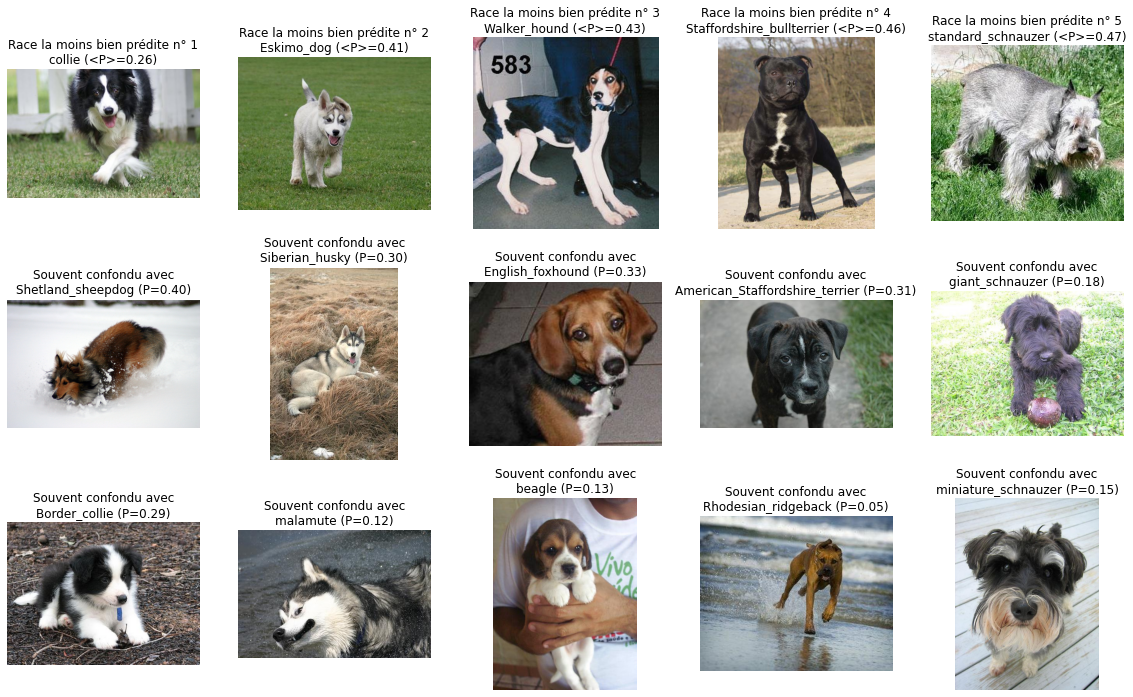

In [273]:
#tab_files_path[['collie' in path for path in tab_files_path]]
### Graphe
plt.figure('Exemple des pires races en termes de prédiction', figsize=(4*5,4*3)), plt.clf()
for n, i in enumerate(mat_pred.values.diagonal().argsort()[:5]):
    probas = mat_pred.values[i]
    index_top_3 = probas.argsort()[-1:-4:-1][probas.argsort()[-1:-4:-1]!=i]
    # Cas particulier : race étiquette <=> j==0
    axe = plt.subplot(3, 5, n + 0*5 + 1)
    axe.set_title(f'Race la moins bien prédite n°{n+1 : >2}\n{np.sort(races)[i]} (<P>={probas[i]:>4.2f})') 
    with Image.open(tab_files_path[[np.sort(races)[i] in path for path in tab_files_path]][0]) as img :
        axe.imshow(img), axe.axis('off')
    for j in range(1,3):
        k = index_top_3[j-1]
        axe = plt.subplot(3, 5, n + j*5 + 1)
        axe.set_title(f'Souvent confondu avec\n{np.sort(races)[k]} (P={probas[k]:>4.2f})')
        with Image.open(tab_files_path[[np.sort(races)[k] in path for path in tab_files_path]][0]) as img :
            axe.imshow(img), axe.axis('off')
del k, j, i, probas, n, index_top_3, img
if sauvegarde_figure :
    plt.savefig(path_fig+'12_mobnet2_b_worst_5.png')

On comprend donc que les races les moins bien prédites sont confondues avec des races... qui leur ressemble énormément (en tout cas, du point de vue du non expert en biologie canine, et sur la seule fois de l'allure).

On pourrait donc presque considérer ces erreurs comme acceptables.

In [277]:
pickle_save(object_to_save=tab_files_path[::4], suffix_title='test_images_files_paths')